
# 🧪 Xenium AP (HFD vs NC)

This notebook is a  pipeline for comparing AP tissues between **HFD** and **NC/NC** in Xenium/10x-style matrices using **Scanpy**.





## 1) Install exact library versions (for reproducibility)

We pin versions to reduce the chance of subtle API/behavior changes breaking analysis.
If   don't need strict reproducibility,   can relax version pins.


In [1]:

# ✅ Install core packages (quietly). Rerun if Colab restarts the runtime.
%pip install -q scanpy==1.11.2 squidpy==1.6.5 harmonypy==0.0.10 geosketch==1.3 gseapy==1.1.3 adjustText==1.3.0 scikit-misc==0.5.1 igraph==0.11.8


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.0/553.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [4]:
%pip install gprofiler-official goatools  seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 13.2 MB/s eta 0:00:00



## 2) Imports & global settings

- We set Scanpy verbosity to show progress without spam.
- We also silence non-critical warnings to keep the log readable.


In [2]:
# --- run this BEFORE %load_ext autoreload ---
# Fix for Python 3.12: provide a compat 'imp.reload' for old autoreload versions
try:
    import imp  # if present, fine (older Python/envs)
except ModuleNotFoundError:
    import types, importlib, sys
    imp = types.ModuleType("imp")
    imp.reload = importlib.reload
    sys.modules["imp"] = imp
# --- end compat shim ---

# now safe to load autoreload
%load_ext autoreload
%autoreload 2


In [3]:

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import warnings

warnings.filterwarnings("ignore")
sc.settings.verbosity = 3


/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name


## 3) Mount Google Drive & configure input paths

**Action required:** Update the two paths below to point to `cell_feature_matrix.h5` files.
We keep them as variables so the rest of the notebook stays unchanged.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

P_HFD = "/content/drive/MyDrive/Run4b_AP_HFD_1/cell_feature_matrix.h5"  # note the space before underscore
P_NC = "/content/drive/MyDrive/Run4b_AP_LFD_6/cell_feature_matrix.h5"   # aka NC/AP



## 4) Load matrices

We use `sc.read_10x_h5` which understands the 10x HDF5 format.


In [7]:

adata_hfd = sc.read_10x_h5(P_HFD)
adata_NC = sc.read_10x_h5(P_NC)

# Make sample IDs explicit in observation names (handy later)
adata_hfd.obs_names = adata_hfd.obs_names + "_HFD"
adata_NC.obs_names  = adata_NC.obs_names  + "_NC"

# Add a group label BEFORE concatenation
adata_hfd.obs["AP"] = "HFD"
adata_NC.obs["AP"]  = "NC"


reading /content/drive/MyDrive/Run4b_AP_HFD_1/cell_feature_matrix.h5
 (0:00:00)
reading /content/drive/MyDrive/Run4b_AP_LFD_6/cell_feature_matrix.h5
 (0:00:00)



## 5) Concatenate once, deterministically

- We use `join="inner"` to keep only shared genes.  
  If the panels differ and   want the union, switch to `join="outer"` (but expect more sparsity).
- We also keep a copy of raw counts in a layer for later.


In [8]:

adata = ad.concat([adata_hfd, adata_NC], label="AP", keys=["HFD","NC"], join="outer")
adata.layers["counts"] = adata.X.copy()
adata


AnnData object with n_obs × n_vars = 45805 × 379
    obs: 'AP'
    layers: 'counts'


## 6) Basic QC metrics (safe `percent_top`)

We cap `percent_top` at the number of genes to avoid index issues on small panels.


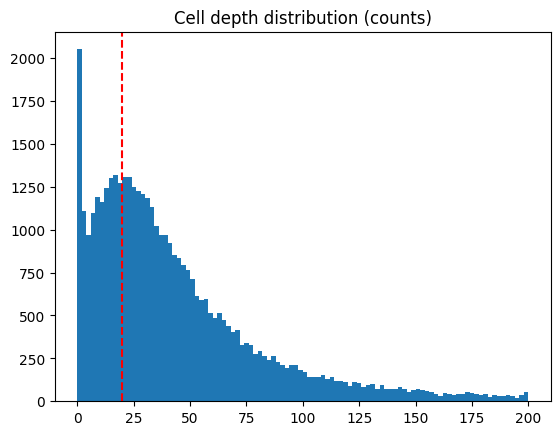

In [9]:

nvars = int(adata.n_vars)
ptops = [k for k in [50, 100, 200, 500] if k <= nvars]
if not ptops: ptops = [min(nvars, 50)]
sc.pp.calculate_qc_metrics(adata, percent_top=ptops, inplace=True, log1p=True)

# Quick look at depth to choose sensible cutoffs
plt.hist(adata.obs["total_counts"], range=(0, 200), bins=100)
plt.axvline(20, color="r", linestyle="--")  # example minimum
plt.title("Cell depth distribution (counts)")
plt.show()



## 7) Filter cells & genes

- **Cells:** drop very low-depth cells and extreme-high outliers (98th percentile).  
- **Genes:** keep genes detected in at least 100 cells (tune to the panel).


In [10]:

# Cells: remove too-low & extreme-high
hi = np.quantile(adata.obs["total_counts"], 0.98)
sc.pp.filter_cells(adata, min_counts=20)
sc.pp.filter_cells(adata, max_counts=hi)

# Genes: keep sufficiently detected features
sc.pp.filter_genes(adata, min_cells=100)


filtered out 12706 cells that have less than 20 counts
filtered out 912 cells that have more than 774.0 counts
filtered out 16 genes that are detected in less than 100 cells



## 8) Normalize & log-transform

We preserve the raw counts in `layers['counts']`, normalize to 10k counts per cell, then `log1p`.
The log-normalized matrix is saved to `layers['lognorm']`.


In [11]:

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["lognorm"] = adata.X.copy()


normalizing counts per cell
    finished (0:00:04)



## 9) Highly variable genes (batch-aware)

We select HVGs with `flavor='seurat_v3'`, **batch-aware** using `batch_key='AP'`.  
`n_top_genes` is clamped to available features to avoid silent truncation.


In [12]:

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=min(2000, adata.n_vars),
    layer="counts", batch_key="AP"
)
adata = adata[:, adata.var["highly_variable"]].copy()
adata


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 32187 × 363
    obs: 'AP', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'lognorm'

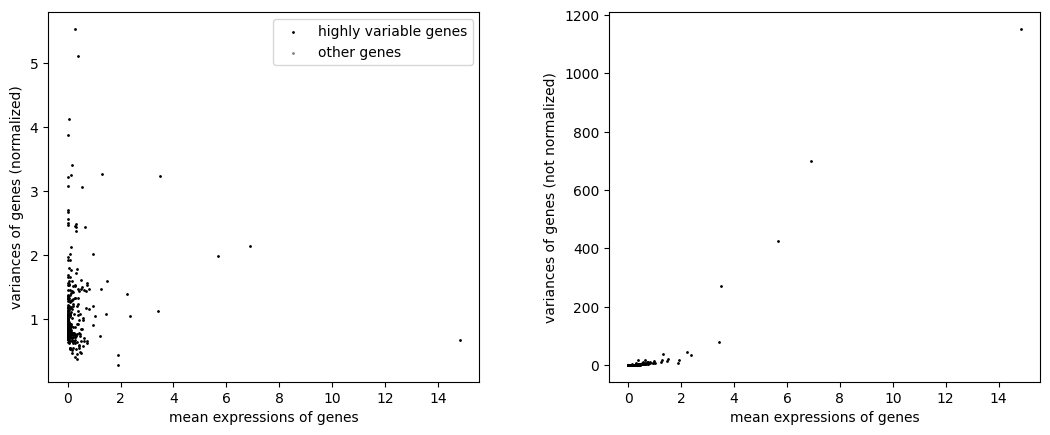

In [13]:
sc.pl.highly_variable_genes(adata)

In [16]:
adata.var[adata.var.highly_variable].index.str.contains('MT-').sum()
adata.var[adata.var.highly_variable].index.str.contains('RPL|RPS').sum()


np.int64(0)

In [15]:
# 1) Compute HVGs
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=min(2000, adata.n_vars),
    layer="counts", batch_key="AP"
)

# 2) Inspect the top HVGs (by rank)
hvg_tbl = (
    adata.var
         .loc[adata.var["highly_variable"], ["highly_variable_rank","means","variances","variances_norm"]]
         .sort_values("highly_variable_rank")
)

# Show top 20 names
top20_genes = hvg_tbl.index[:20].tolist()
print(top20_genes)

# (optional) display a tidy table
print(hvg_tbl.head(20))

# 3) If   still want to subset afterward:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
['Retnla', 'Snap25', 'Asprv1', 'Crct1', 'Mmrn1', 'Scg2', 'Car3', 'Slc17a7', 'Col2a1', 'Gad1', 'Nnat', 'Myh11', 'Vwf', 'Tnnc1', 'Gria2', 'Cpa3', 'Lor', 'Wif1', 'Folr2', 'Omp']
         highly_variable_rank     means   variances  variances_norm
Retnla                    3.0  0.270233    4.325530        5.539756
Snap25                    4.0  0.037065    0.532865        4.134806
Asprv1                    8.5  3.503371  270.395836        3.239760
Crct1                     9.0  1.298009   37.815929        3.264250
Mmrn1                     9.5  0.120701    0.871002        3.252705
Scg2                      9.5  0.021624    0.385166        3.086282
Car3                     10.0  0.537981   11.095144        3.070363
Slc17a7 

In [17]:
import scanpy as sc
import pandas as pd

def top_hvg_by_group(
    adata,
    group_key="AP",
    groups=("HFD", "NC"),
    n_top=50,
    layer="counts",
    flavor="seurat_v3",
):
    """
    Compute top n HVGs separately within each group in `adata.obs[group_key]`.
    Returns a tidy DataFrame and a dict of lists (per-group gene names).
    """
    all_tables = []
    per_group_genes = {}

    for g in groups:
        adg = adata[adata.obs[group_key] == g].copy()
        if layer is not None and layer in adg.layers:
            # Seurat v3 expects counts (not log1p) if possible
            sc.pp.highly_variable_genes(
                adg,
                flavor=flavor,
                n_top_genes=min(n_top, adg.n_vars),
                layer=layer
            )
        else:
            sc.pp.highly_variable_genes(
                adg,
                flavor=flavor,
                n_top_genes=min(n_top, adg.n_vars)
            )

        # Rank table for this group
        if "highly_variable_rank" in adg.var.columns:
            hv_tbl = (adg.var.loc[adg.var["highly_variable"],
                                  ["highly_variable_rank", "means", "variances", "variances_norm"]]
                            .sort_values("highly_variable_rank"))
        else:
            # Fallback if rank missing: sort by normalized variance
            hv_tbl = (adg.var.loc[adg.var["highly_variable"],
                                  ["means", "variances", "variances_norm"]]
                            .sort_values("variances_norm", ascending=False))

        hv_tbl = hv_tbl.head(n_top).reset_index().rename(columns={"index": "gene"})
        hv_tbl.insert(0, "group", g)
        all_tables.append(hv_tbl)
        per_group_genes[g] = hv_tbl["gene"].tolist()

    result_df = pd.concat(all_tables, ignore_index=True)

    # Pretty print to console
    for g in groups:
        print(f"\nTop {n_top} HVGs in {g}:")
        print(per_group_genes[g])

    return result_df, per_group_genes

# ---- run it ----
hvg_df, hvg_lists = top_hvg_by_group(adata, group_key="AP", groups=("HFD","NC"), n_top=50, layer="counts")

# Optiona


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)

Top 50 HVGs in HFD:
['Retnla', 'Hp', 'Mmrn1', 'Crct1', 'Asprv1', 'Snap25', 'Cpa3', 'Gad1', 'Scg2', 'Nnat', 'Vwf', 'Car3', 'Lor', 'Ly6g6c', 'Ager', 'Myh11', 'Calm4', 'Wif1', 'Omp', 'Slc17a7', 'Krt16', 'Aqp3', 'Ace2', 'Gm94', 'Col2a1', 'Col17a1', 'Prx', 'Rbp2', 'Folr2', 'Acan', 'Lyve1', 'Sbsn', 'Tnnc1', 'Atp6v0d2', 'Gria2', 'Serpinb11', 'Dcpp2', 'Gatm', 'Celf3', 'Kcna1', 'Retn', 'Selenbp1', 'Dsc3', 'Comp', 'Cnfn', 'Ccl9', 'F13a1', 'Gpx2', 'Mpeg1', 'Ta


## 10) PCA (no zero-centering)

We skip zero-centering to play nicely with sparse/counted data and cosine metrics.  
If   prefer standard PCA, set `zero_center=True`.


... be careful when using `max_value` without `zero_center`.
computing PCA
    with n_comps=30
    finished (0:00:00)


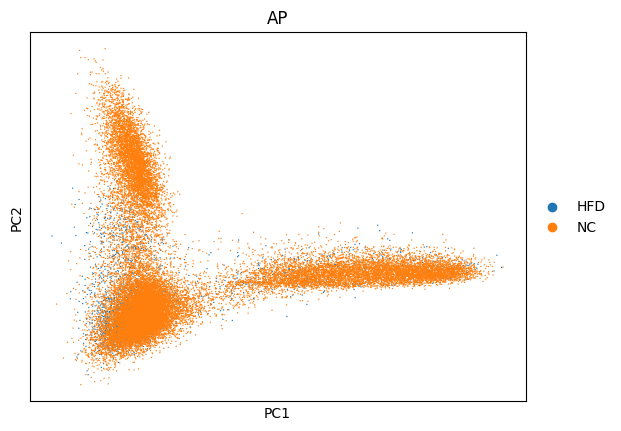

In [18]:
# @title

sc.pp.scale(adata, zero_center=False, max_value=10)
sc.tl.pca(adata, n_comps=min(30, adata.n_vars), svd_solver="arpack")
sc.pl.pca(adata, color="AP", show=True)



## 11) (Optional) Quick UMAP **before** batch correction

This is useful just to visualize batch effects.   can skip this section for speed.


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:33)


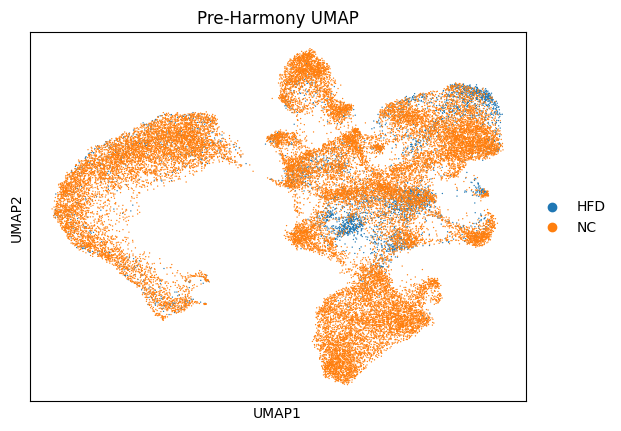

In [19]:

sc.pp.neighbors(adata, metric="cosine")
sc.tl.umap(adata)
sc.pl.umap(adata, color="AP", title="Pre-Harmony UMAP", show=True)



## 12) Harmony batch correction

We integrate by the `AP` key, producing `X_pca_harmony` which we use for neighbors/UMAP/clustering.


In [20]:

sc.external.pp.harmony_integrate(adata, key="AP", random_state=0)


2025-12-06 16:05:52,479 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-12-06 16:06:02,187 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-12-06 16:06:02,639 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-12-06 16:06:20,489 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-12-06 16:06:37,247 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-12-06 16:06:54,421 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-12-06 16:07:11,222 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations



## 13) Neighbors & UMAP on Harmony space

We compute a KNN graph using **cosine** distance on `X_pca_harmony`, then run UMAP.


In [21]:

sc.pp.neighbors(adata, use_rep="X_pca_harmony", metric="cosine")
sc.tl.umap(adata)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:31)


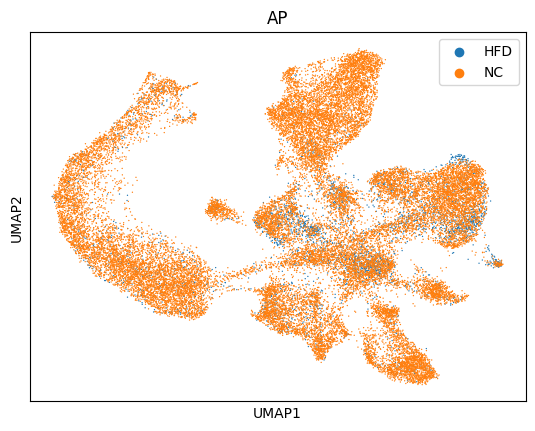

In [22]:
ax = sc.pl.umap(adata, color=["AP"], title="AP", show=False)
ax.legend(
    loc="upper right",   # choose location (e.g., 'upper left', 'center', etc.)
    bbox_to_anchor=(1, 1)  # tweak positioning if needed
    )


## 14) Leiden clustering

`n_iterations=-1` means **run until convergence** (valid in modern Scanpy).  
Tune `resolution` to change granularity.


running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


AP,HFD,NC
leiden,,
0,668,2968
1,199,1178
2,200,642
3,467,1180
4,64,750
5,528,1563
6,234,1663
7,219,2869
8,76,73


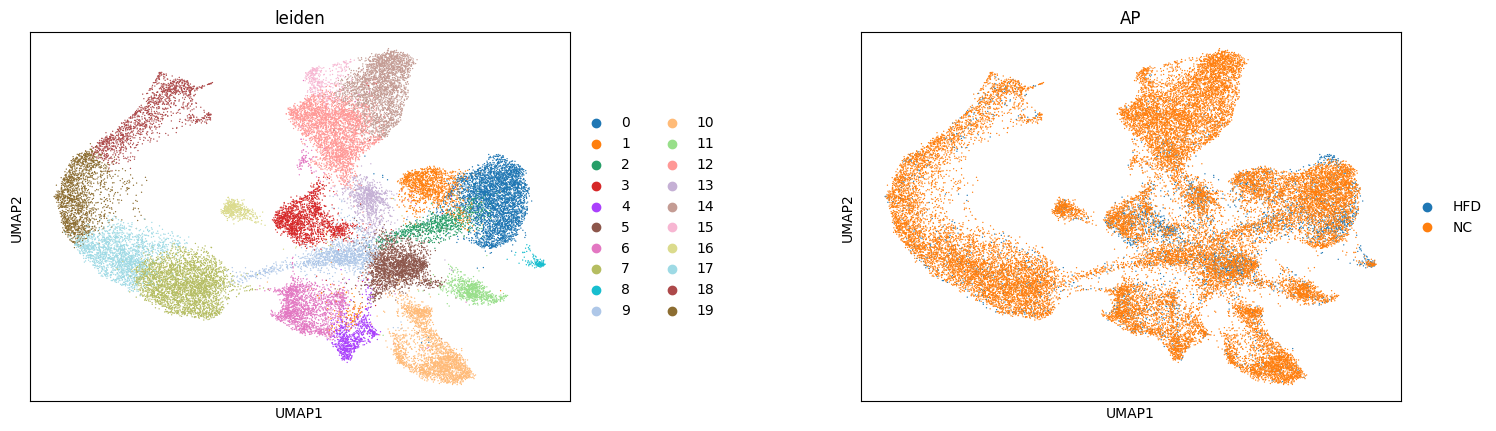

In [23]:

sc.tl.leiden(adata, flavor="igraph", n_iterations=-1, resolution=1)
display(adata.obs.groupby(['leiden', 'AP']).size().unstack(fill_value=0))
sc.pl.umap(adata, color=["leiden","AP"], wspace=0.4, show=True)



## 15) Marker genes (per cluster)

We rank genes per Leiden cluster using the **log-normalized** layer.


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)
    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_leiden']`


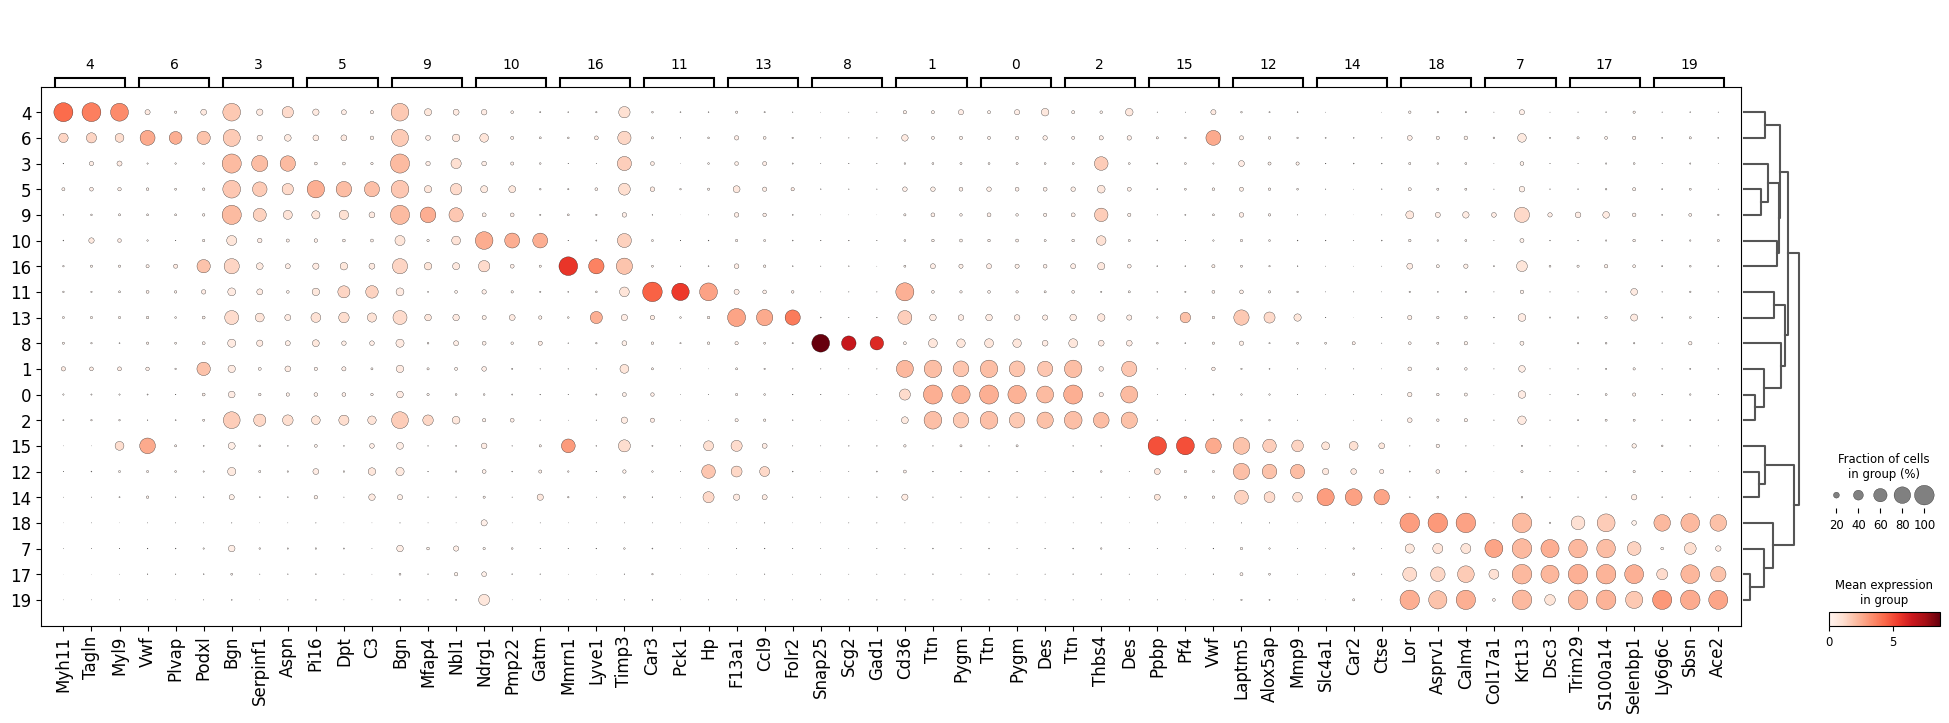

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Ttn,Cd36,Ttn,Bgn,Myh11,Pi16,Vwf,Col17a1,Snap25,Bgn,Ndrg1,Car3,Laptm5,F13a1,Slc4a1,Ppbp,Mmrn1,Trim29,Lor,Ly6g6c
1,Pygm,Ttn,Thbs4,Serpinf1,Tagln,Dpt,Plvap,Krt13,Scg2,Mfap4,Pmp22,Pck1,Alox5ap,Ccl9,Car2,Pf4,Lyve1,S100a14,Asprv1,Sbsn
2,Des,Pygm,Des,Aspn,Myl9,C3,Podxl,Dsc3,Gad1,Nbl1,Gatm,Hp,Mmp9,Folr2,Ctse,Vwf,Timp3,Selenbp1,Calm4,Ace2
3,Hrc,Des,Pygm,Lum,Mylk,Lum,Cav1,Trim29,Gria2,Thbs4,Prx,Cd36,Rac2,Ctss,Hmbs,Slc14a1,Cavin2,Krt13,Crct1,Krt16
4,Cryab,Podxl,Bgn,Wif1,Mustn1,Pcolce2,Eng,S100a14,Aplp1,Nupr1,Cryab,Retn,Mpeg1,Laptm5,Fech,Laptm5,Cp,Serpinb5,Sbsn,Lor
5,Pgam2,Rgs5,Cryab,Thbs4,Cnn1,Bgn,Tie1,Anxa8,Pnmal2,S100a4,Kcna1,Mgll,Ctss,Lyve1,Slc25a37,Mmrn1,Podxl,Them5,Krt16,S100a14
6,Sypl2,Cav1,Serpinf1,Timp3,Itga8,Serpinf1,Bgn,Serpinb5,Hap1,Serpinf1,Timp3,Ccdc80,Hp,Cd36,Hemgn,Cavin2,Tie1,Gm94,Ly6g6c,Calm4
7,Pvalb,Aqp1,Hrc,Ptn,Bgn,Htra3,Cavin2,Sdc1,Ldhb,Igfbp6,Fxyd6,Cav1,Cybb,Cfh,Stmn1,Ctla2a,Kdr,Sbsn,Krt13,Them5
8,Myoz1,Kdr,Mfap4,Cfh,Ccn3,Mfap5,Rgs5,Anxa2,Nap1l5,Ccdc80,Stmn1,C3,Mmp8,Pf4,Mpo,Alox5ap,Fxyd6,Aqp3,Serpinb11,Gpx2
9,Fxyd6,Hrc,Ccdc80,Nupr1,Prss23,Ccdc80,Aqp1,Them5,Cplx2,Aqp1,Ldhb,Dpt,Ncf4,C5ar1,Rac2,Rac2,Cav1,Gpx2,Ace2,Gm94


In [24]:

sc.tl.rank_genes_groups(adata, groupby="leiden", layer="lognorm", pts=True, method="wilcoxon")
axes = sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, show=False)
axes["mainplot_ax"].tick_params(axis="y", labelsize=12)
axes["mainplot_ax"].tick_params(axis="x", labelsize=12)
plt.show()

# Extract a tidy table of top-N genes per cluster
rg = adata.uns['rank_genes_groups']
groups = rg['names'].dtype.names
TOPN = 10
top_markers = pd.DataFrame({g: rg['names'][g][:TOPN] for g in groups})
top_markers



## 17) (Optional) Map clusters to cell types

Provide mapping dict below. Keep the keys as strings if Leiden labels are strings.


Unmapped clusters: []
Cell type annotation
Oral epithelial keratinocyte                   8047
Skeletal muscle                                3636
Neutrophils                                    3016
Erythroid                                      2525
Schwann cell / myelinating glia                2409
Fibroblast / Pi16⁺ stromal                     2091
Endothelial                                    1897
Fibroblast / ECM structural                    1647
Vascular smooth muscle / pericyte              1377
Fibroblast / ECM-remodeling                    1314
Macrophage                                      863
Myofibroblast / contractile fibroblast          842
Smooth muscle / mural cell                      814
Adipose-like stromal / metabolic fibroblast     730
Endothelial / lymphatic                         444
Platelet / megakaryocyte                        386
Peripheral neuron                               149
Name: count, dtype: int64


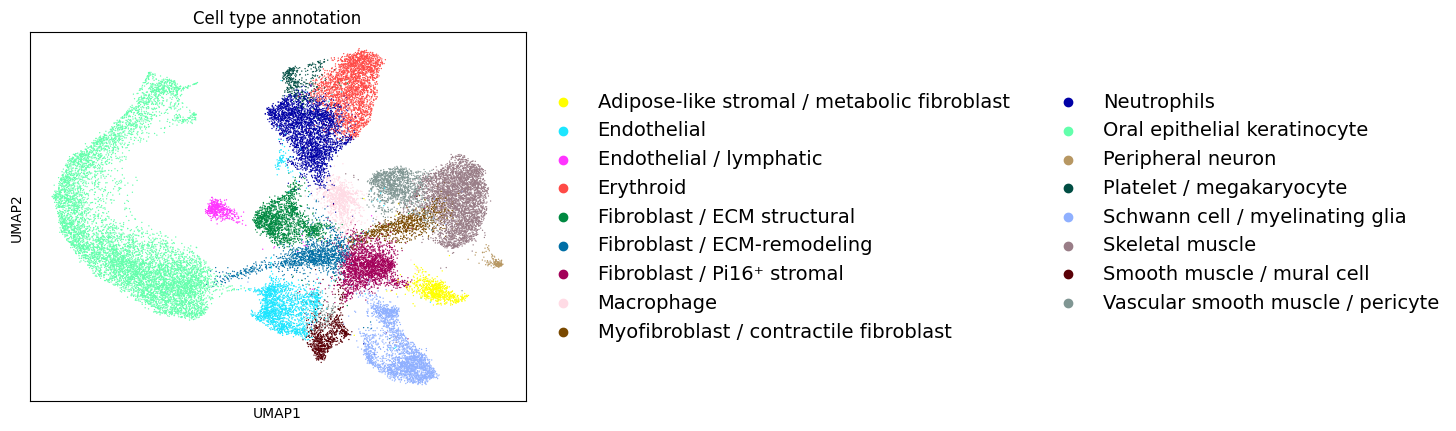

In [25]:
# --- 1️⃣ Define mapping dictionary ---
cluster_to_celltype = {
    "0" : "Skeletal muscle",
    "1" : "Vascular smooth muscle / pericyte",
    "2" : "Myofibroblast / contractile fibroblast",
    "3" : "Fibroblast / ECM structural",
    "4" : "Smooth muscle / mural cell",
    "5" : "Fibroblast / Pi16⁺ stromal",
    "6" : "Endothelial",
    "7" : "Oral epithelial keratinocyte",
    "8" : "Peripheral neuron",
    "9" : "Fibroblast / ECM-remodeling",
    "10": "Schwann cell / myelinating glia",
    "11": "Adipose-like stromal / metabolic fibroblast",
    "12": "Neutrophils",
    "13": "Macrophage",
    "14": "Erythroid",
    "15": "Platelet / megakaryocyte",
    "16": "Endothelial / lymphatic",
    "17": "Oral epithelial keratinocyte",
    "18": "Oral epithelial keratinocyte",
    "19": "Oral epithelial keratinocyte"
}

# --- 2️⃣ Create the Leiden string labels safely ---
adata.obs["leiden"] = adata.obs["leiden"].astype(str).str.strip()

# --- 3️⃣ Map clusters to cell-type names ---
adata.obs["Cell type annotation"] = adata.obs["leiden"].map(cluster_to_celltype)

# --- 4️⃣ Check if any unmapped clusters remain (should print empty list) ---
unmapped = sorted(set(adata.obs["leiden"].unique()) - set(cluster_to_celltype.keys()))
print("Unmapped clusters:", unmapped)

# --- 5️⃣ Verify mapping worked ---
print(adata.obs["Cell type annotation"].value_counts())

# --- 6️⃣ Make category list ONLY from existing data ---
adata.obs["Cell type annotation"] = pd.Categorical(
    adata.obs["Cell type annotation"],
    categories=sorted(adata.obs["Cell type annotation"].dropna().unique()),
    ordered=False
)

# --- 7️⃣ Plot without fake 'Unassigned' in legend ---
palette = sc.pl.palettes.default_102  # plenty of distinct colors
sc.pl.umap(
    adata,
    color="Cell type annotation",
    legend_loc="right margin",
    legend_fontsize=14,
    palette=palette[:len(adata.obs["Cell type annotation"].cat.categories)],
    frameon=True,
    show=True
)


[NC] macrophage clusters: ['13']
[NC] neutrophil clusters: ['12']
[NC] used clusters (union): ['12', '13']
ranking genes
    finished: added to `.uns['rg_lineage_nc']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


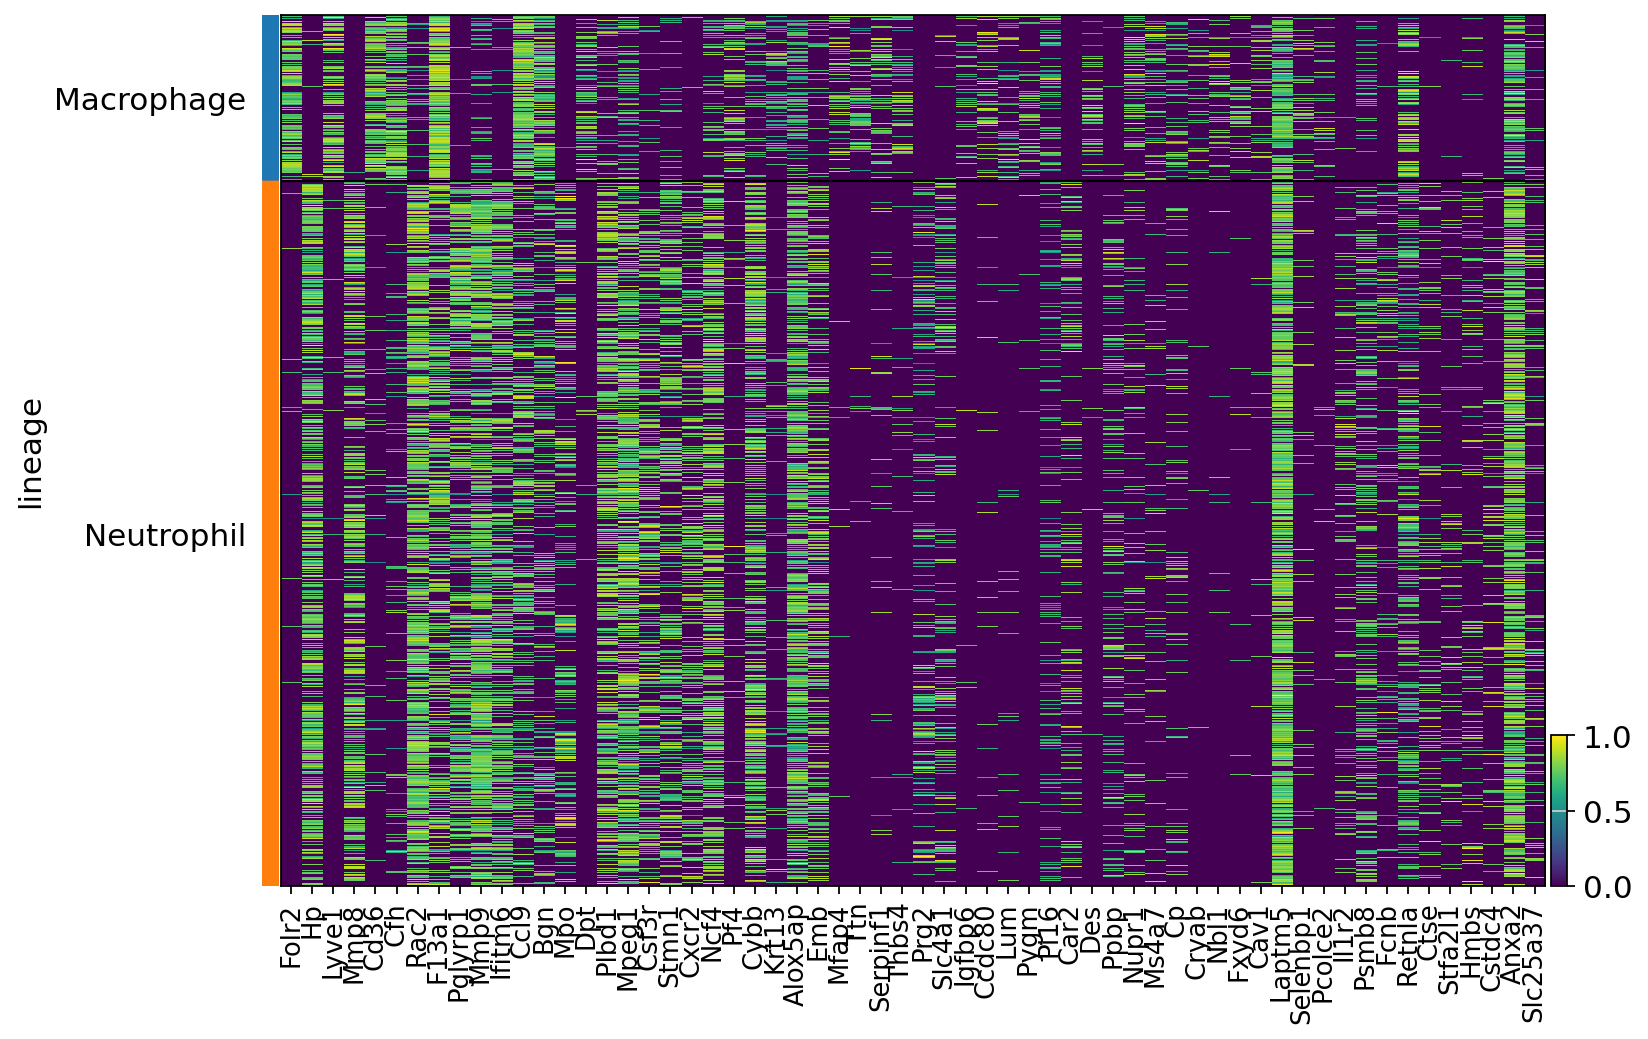

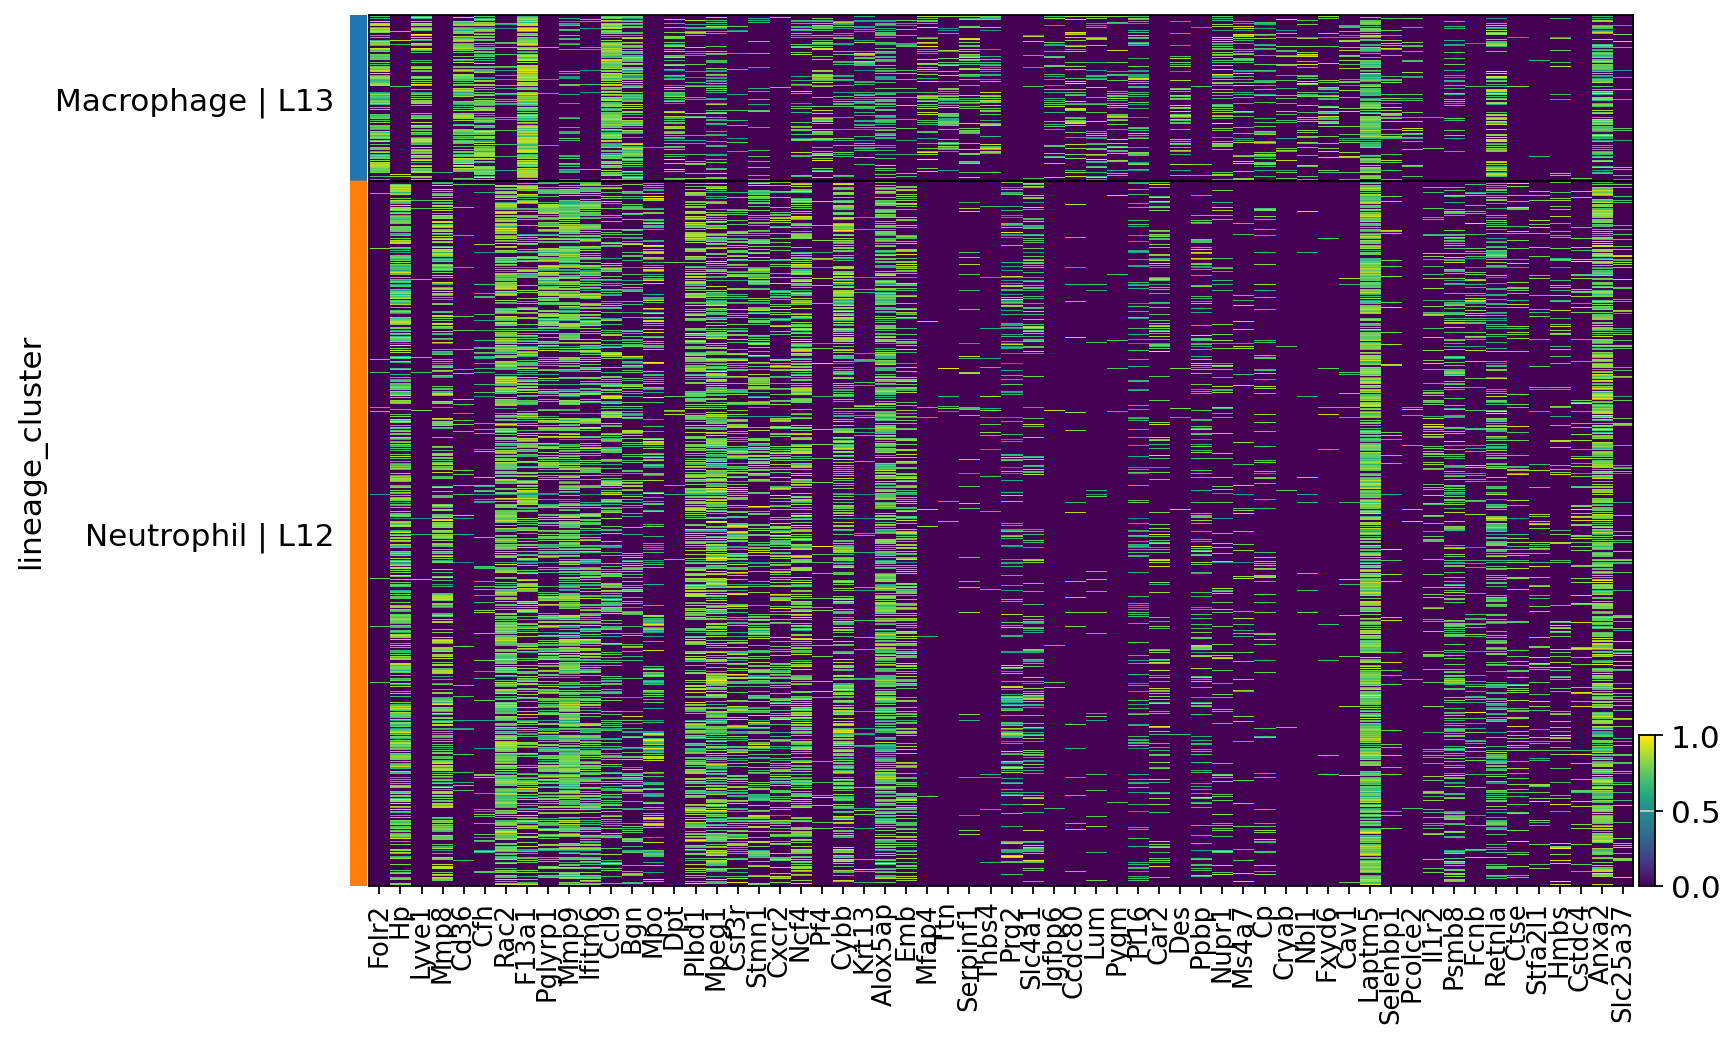

[NC] Shown 60 genes. Increase HEIGHT_PER_GENE or LEFT_MARGIN if labels still clip.


In [27]:
# @title
# ===============================================
# Neutrophil vs Macrophage  — TALL HEATMAPS WITH FULL GENE NAMES
# ===============================================

import numpy as np, pandas as pd, scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sp

# ------------------------
# Config (tweak as needed)
# ------------------------
TOP_PER_GROUP   = 30   # top N genes per lineage to seed the panel
MAX_GENES       = 60   # cap total gene rows in heatmap
MIN_HITS        = 3    # signature hits required to label a cluster as a lineage
HEIGHT_PER_GENE = 0.35 # inches per gene row -> figure height
LEFT_MARGIN     = 0.45 # more = wider left margin for long gene names
BOTTOM_MARGIN   = 0.65 # add some bottom space for group labels
FONT_SIZE       = 14   # global font size for readability
USE_SWAP_AXES   = False  # True -> put genes on X (useful for many clusters)

# (Optional) set global font sizes for all plots
sc.set_figure_params(scanpy=True, fontsize=FONT_SIZE)

# Safety checks
assert "leiden" in adata.obs, "Missing adata.obs['leiden']"
assert "AP" in adata.obs, "Missing adata.obs['AP'] (expected 'HFD' and 'NC')"

# ------------------------
# Signatures to detect clusters
# ------------------------
MACRO_SIG = {
    # macrophage/monocyte core
    "Csf1r","Adgre1","Ms4a7","Lyz2","F13a1","Mpeg1","Cd68","Itgam","Lgals3",
    # tissue macrophage / foam-like markers often seen in sets
    "Folr2","Pf4","Cd36","F13a1","Ccl9","Alox5ap","Ctss","Laptm5"
}
NEUTRO_SIG = {
    "S100a8","S100a9","Elane","Prtn3","Mpo","Mmp9","Camp","Lcn2","Cxcr2",
    "Rac2","Stmn1","Ifitm6","Ltf","Ms4a3","Hp"
}

# ------------------------
# Make/refresh top_markers (top 10 names per cluster) if absent
# ------------------------
if 'top_markers' not in globals():
    assert 'rank_genes_groups' in adata.uns, "Need either `top_markers` or `adata.uns['rank_genes_groups']`."
    rg = adata.uns['rank_genes_groups']
    groups = rg['names'].dtype.names
    TOPN = 10
    top_markers = pd.DataFrame({g: rg['names'][g][:TOPN] for g in groups})

# Detect macrophage & neutrophil clusters from their top markers
macrophage_clusters, neutrophil_clusters = [], []
for clust in top_markers.columns:
    genes = pd.Series(top_markers[clust]).dropna().astype(str)
    gset  = set(genes)
    if len(gset & MACRO_SIG)   >= MIN_HITS: macrophage_clusters.append(str(clust))
    if len(gset & NEUTRO_SIG)  >= MIN_HITS: neutrophil_clusters.append(str(clust))

# (Optional) override if   already know IDs:
macrophage_clusters = ['13']
neutrophil_clusters = ['12']

target_clusters = sorted(set(macrophage_clusters + neutrophil_clusters))
print(f"[NC] macrophage clusters: {macrophage_clusters or '—'}")
print(f"[NC] neutrophil clusters: {neutrophil_clusters or '—'}")
print(f"[NC] used clusters (union): {target_clusters or '—'}")
if not macrophage_clusters or not neutrophil_clusters:
    raise ValueError("Need at least one macrophage and one neutrophil cluster to compare.")

# ------------------------
# Subset to NC only & target clusters
# ------------------------
ad_nc = adata[(adata.obs["AP"] == "NC") & (adata.obs["leiden"].astype(str).isin(target_clusters))].copy()
if ad_nc.n_obs == 0:
    raise ValueError("No NC cells found for the detected target clusters.")

# Ensure a normalized/log layer to plot consistently
LAYER_NAME = "lognorm" if "lognorm" in (adata.layers or {}) else None

def _ensure_lognorm(ad):
    global LAYER_NAME
    if LAYER_NAME is None:
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.layers["lognorm"] = ad.X.copy()
        LAYER_NAME = "lognorm"
    return LAYER_NAME

lyr = _ensure_lognorm(ad_nc)

# ------------------------
# Build lineage label (Macrophage vs Neutrophil)
# ------------------------
cluster_to_lineage = {c: "Macrophage" for c in macrophage_clusters}
cluster_to_lineage.update({c: "Neutrophil" for c in neutrophil_clusters})
ad_nc.obs["lineage"] = ad_nc.obs["leiden"].astype(str).map(cluster_to_lineage).astype("category")

# ------------------------
# Rank genes distinguishing the two lineages *within NC*
# ------------------------
sc.tl.rank_genes_groups(ad_nc, groupby="lineage", method="wilcoxon", layer=lyr, pts=True, key_added="rg_lineage_nc")

df_mac = sc.get.rank_genes_groups_df(ad_nc, group="Macrophage", key="rg_lineage_nc").head(TOP_PER_GROUP)
df_neu = sc.get.rank_genes_groups_df(ad_nc, group="Neutrophil", key="rg_lineage_nc").head(TOP_PER_GROUP)

panel = pd.unique(pd.concat([df_mac["names"], df_neu["names"]], ignore_index=True)).tolist()
panel = [g for g in panel if g in ad_nc.var_names]
panel = panel[:MAX_GENES]
if not panel:
    raise ValueError("No panel genes found in var_names; reduce TOP_PER_GROUP or check data.")

# ------------------------
# Robust per-lineage averages to order genes by |Neu - Mac| (avoid AxisError)
# ------------------------
def _get_layer_matrix(ad, layer_name):
    """Return dense 2D numpy array for aggregation."""
    if layer_name and (layer_name in ad.layers):
        M = ad.layers[layer_name]
    else:
        M = ad.X
    if sp.issparse(M):
        M = M.toarray()
    else:
        M = np.asarray(M)
    if M.ndim == 1:
        M = M.reshape(-1, 1)
    return M

def avg_expr_by_lineage(ad, genes, lineage_label, layer_name):
    sub = ad[ad.obs["lineage"] == lineage_label, genes]
    if sub.n_obs == 0:
        return np.zeros(len(genes), dtype=float)
    M = _get_layer_matrix(sub, layer_name)
    if M.size == 0:
        return np.zeros(len(genes), dtype=float)
    return M.mean(axis=0).ravel()

mac_avg = avg_expr_by_lineage(ad_nc, panel, "Macrophage", lyr)
neu_avg = avg_expr_by_lineage(ad_nc, panel, "Neutrophil",  lyr)

# Order genes by descending absolute difference
order_idx = np.argsort(-(np.abs(neu_avg - mac_avg)))
panel = [panel[i] for i in order_idx]
n_genes = len(panel)

# ------------------------
# Heatmap 1: lineage-level (Macrophage vs Neutrophil), NC only
# ------------------------
if not USE_SWAP_AXES:
    sc.pl.heatmap(
        ad_nc,
        var_names=panel,
        groupby="lineage",
        layer=lyr,
        standard_scale="var",
        show_gene_labels= True,
        figsize=(16, max(4, HEIGHT_PER_GENE * n_genes)),  # TALL height
        show=False
    )
    fig = plt.gcf()
    fig.subplots_adjust(left=LEFT_MARGIN, bottom=BOTTOM_MARGIN)  # extra margins for labels
    # Optional: slightly larger y-tick labels
    for ax in fig.axes:
        ax.tick_params(axis='y', labelsize=FONT_SIZE)
    plt.show()
else:
    # Put genes on X if   prefer wide plots
    sc.pl.heatmap(
        ad_nc,
        var_names=panel,
        groupby="lineage",
        layer=lyr,
        standard_scale="var",
        swap_axes=True,
        figsize=(max(16, 0.22 * n_genes), 6),
        show_gene_labels= True,
        show=False
    )
    fig = plt.gcf()
    for ax in fig.axes:
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(90)
            lbl.set_ha("center")
    fig.subplots_adjust(bottom=max(BOTTOM_MARGIN, 0.35))  # more bottom margin for rotated labels
    plt.show()

# ------------------------
# Heatmap 2: per-cluster (each Leiden) within the two lineages (NC)
# ------------------------
ad_nc.obs["lineage_cluster"] = ad_nc.obs["lineage"].astype(str) + " | L" + ad_nc.obs["leiden"].astype(str)

if not USE_SWAP_AXES:
    sc.pl.heatmap(
        ad_nc,
        var_names=panel,
        groupby="lineage_cluster",
        layer=lyr,
        standard_scale="var",
        show_gene_labels= True,
        figsize=(16, max(4, HEIGHT_PER_GENE * n_genes)),  # TALL height
        show=False
    )
    fig = plt.gcf()
    fig.subplots_adjust(left=LEFT_MARGIN, bottom=BOTTOM_MARGIN)
    for ax in fig.axes:
        ax.tick_params(axis='y', labelsize=FONT_SIZE)
    plt.show()
else:
    sc.pl.heatmap(
        ad_nc,
        var_names=panel,
        groupby="lineage_cluster",
        layer=lyr,
        standard_scale="var",
        swap_axes=True,
        show_gene_labels= True,
        figsize=(max(16, 0.35 * n_genes), 6),
        show=False
    )
    fig = plt.gcf()
    for ax in fig.axes:
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(90)
            lbl.set_ha("center")
    fig.subplots_adjust(bottom=max(BOTTOM_MARGIN, 0.40))
    plt.show()

print(f"[NC] Shown {n_genes} genes. Increase HEIGHT_PER_GENE or LEFT_MARGIN if labels still clip.")



## 18) Save key outputs

We save:
- the processed AnnData (`.h5ad`),
- a CSV with per-cluster counts by group,
- a CSV of top markers per cluster.



## Appendix — Useful knobs to tune

- **Filtering**
  - `min_counts` (cells): default 20; raise/lower based on the histogram.
  - `max_counts` (cells): we use the 98th percentile to drop ultra-high depth.
  - `min_cells` (genes): default 100; set per panel size.
- **HVGs**
  - `n_top_genes`: 1,000–3,000 typical; here we clamp to available features.
- **Clustering**
  - `resolution`: higher → more clusters; try 0.6–1.5.
- **Distance metric**
  - We use **cosine** for neighbors; Euclidean is also fine, but cosine is robust in high‑dimensional, scaled spaces.
- **Batch correction**
  - Harmony key is `AP` (HFD vs NC). If   integrate more batches (e.g., donors), add/adjust keys.



# 🔬 Cluster-focused analysis (post-clustering)
**Goal:** After Leiden clustering, pick one cluster (or a small set), compare **HFD vs NC/NC** *within that cluster*, visualize a **heatmap** (keep this; drop volcano), and run **GO:BP enrichment** via **g:Profiler** and **gseapy** (using the **second** gseapy bar format).



## 0) Requirements
- This notebook expects an in-memory `adata` from main pipeline, with:
  - `adata.obs['leiden']` containing cluster labels
  - `adata.obs['AP']` labeling the two groups (e.g., **HFD** vs **NC** or **HFD** vs **NC**)
  - optional `adata.layers['lognorm']` containing log-normalized data
- If   prefer to load a saved `.h5ad`,   may add a small IO cell to read it first.



## 1) Parameters
Set the cluster(s) of interest and a few plotting thresholds.


## Mcrophage subset

In [28]:

# Pick one or more Leiden clusters (as strings, matching adata.obs['leiden'])
TARGET_CLUSTERS = ["13"]   # e.g., ["10"] or ["6", "7"]

# Differential thresholds
PADJ_CUT   = 0.05
LOG2FC_CUT = 0.75

# Heatmap genes to show (up/down each)
N_GENES_UP   = 20
N_GENES_DOWN = 20

# Random seed for equal downsampling by group
RSEED = 0



## 2) Subset the data to chosen cluster(s)
We subset **after** clustering and keep only the cells from the selected Leiden cluster(s).


In [29]:

import numpy as np
import pandas as pd
import scanpy as sc

assert 'leiden' in adata.obs.columns, "Leiden labels not found in adata.obs['leiden']."
assert 'AP' in adata.obs.columns, "Group labels not found in adata.obs['AP']."

# Validate cluster labels
target = [str(c) for c in TARGET_CLUSTERS]
present = set(adata.obs['leiden'].astype(str).unique())
missing = [c for c in target if c not in present]
if missing:
    raise ValueError(f"Requested clusters {missing} not in adata.obs['leiden'] = {sorted(present)}")

# Subset
sel = adata.obs['leiden'].astype(str).isin(target)
adata_sub = adata[sel].copy()
print("Subset size:", adata_sub.n_obs, "cells,", adata_sub.n_vars, "genes")

# Inspect group balance
print("\nGroup counts within subset:")
print(adata_sub.obs['AP'].value_counts())


Subset size: 863 cells, 363 genes

Group counts within subset:
AP
NC     678
HFD    185
Name: count, dtype: int64



## 3) Minimal re-prep (optional)
For a single cluster, we typically **skip HVG re-selection** and reuse the existing normalized layer if available.
If `layers['lognorm']` is missing, we quickly normalize/log-transform here for safety.


In [30]:

# Ensure we have a normalized/log layer
layer_used = "lognorm" if "lognorm" in (adata_sub.layers or {}) else None
if layer_used is None:
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    sc.pp.log1p(adata_sub)
    adata_sub.layers["lognorm"] = adata_sub.X.copy()
    layer_used = "lognorm"
print("Using expression layer:", layer_used)


Using expression layer: lognorm



## 4) Differential expression (HFD vs NC/NC) **within** the subset
We run `rank_genes_groups` on `groupby='AP'` to find genes up/down in **HFD** relative to the other group (NC/NC).


In [31]:

# Identify the two labels present (must be exactly two; assert for safety)
groups_present = list(adata_sub.obs['AP'].astype(str).unique())
if len(groups_present) != 2:
    raise ValueError(f"Expected exactly 2 groups in AP; found {groups_present}")

# Make sure 'HFD' is first for consistent interpretation
if "HFD" not in groups_present:
    raise ValueError(f"'HFD' not found in AP groups: {groups_present}")
other_group = [g for g in groups_present if g != "HFD"][0]  # "NC" or "NC"

# Run DE
sc.tl.rank_genes_groups(
    adata_sub,
    groupby="AP",
    method="wilcoxon",
    pts=True,
    key_added="rg_subset",
    layer=layer_used
)

# Get dataframes for HFD and the other group
df_hfd = sc.get.rank_genes_groups_df(adata_sub, group="HFD", key="rg_subset")
df_oth = sc.get.rank_genes_groups_df(adata_sub, group=other_group, key="rg_subset")

# Helpers
import numpy as np

def add_log2fc(df):
    d = df.copy()
    if "log2fc" not in d.columns:
        d["log2fc"] = d["logfoldchanges"] / np.log(2)
    return d

def sig_up(df, p=0.05, l2fc=LOG2FC_CUT):
    d = add_log2fc(df)
    return d[(d["pvals_adj"] <= p) & (d["log2fc"] >= l2fc)]

def sig_down(df, p=0.05, l2fc=LOG2FC_CUT):
    d = add_log2fc(df)
    return d[(d["pvals_adj"] <= p) & (d["log2fc"] <= -l2fc)]

# Significant sets
hfd_up   = sig_up(df_hfd, p=PADJ_CUT, l2fc=LOG2FC_CUT)
hfd_down = sig_down(df_hfd, p=PADJ_CUT, l2fc=LOG2FC_CUT)
oth_up   = sig_up(df_oth, p=PADJ_CUT, l2fc=LOG2FC_CUT)   # up in other group
oth_down = sig_down(df_oth, p=PADJ_CUT, l2fc=LOG2FC_CUT) # down in other group

print("Sig(HFD up):", len(hfd_up), "| Sig(HFD down):", len(hfd_down))
print(f"Sig({other_group} up):", len(oth_up), "| Sig({other_group} down):", len(oth_down))


ranking genes
    finished: added to `.uns['rg_subset']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Sig(HFD up): 15 | Sig(HFD down): 5
Sig(NC up): 5 | Sig({other_group} down): 15


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


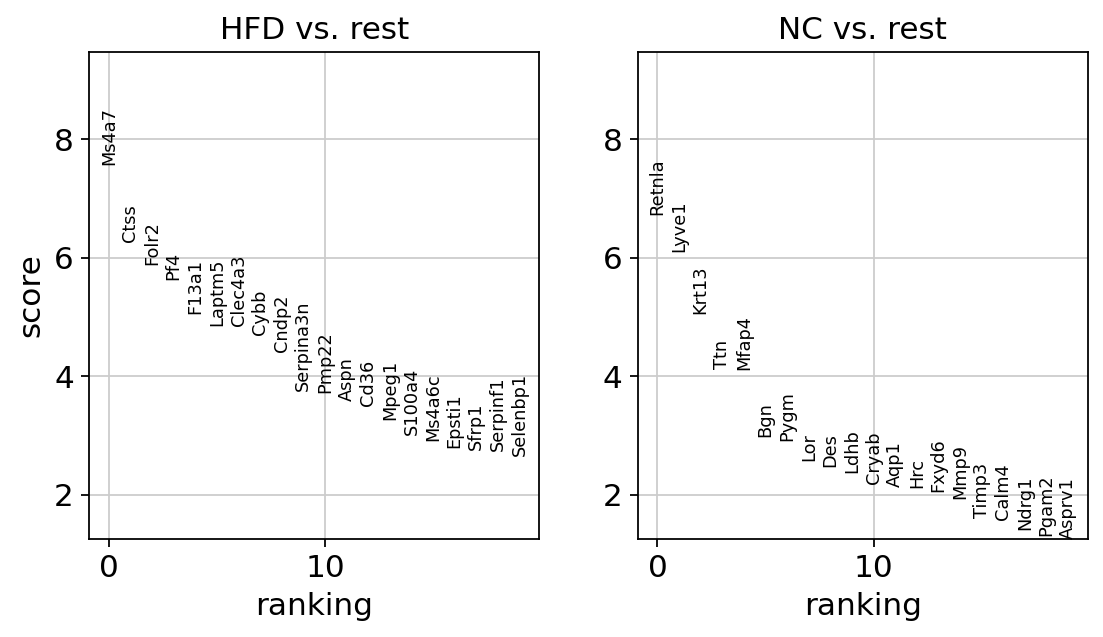

   names    scores  logfoldchanges         pvals     pvals_adj  pct_nz_group  \
0  Ms4a7  7.576313        3.143379  3.555128e-14  1.290511e-11      0.594595   
1   Ctss  6.268062        1.583644  3.655704e-10  4.423401e-08      0.918919   
2  Folr2  5.872574        1.945449  4.290787e-09  3.115112e-07      0.875676   
3    Pf4  5.622671        2.252651  1.880277e-08  1.137567e-06      0.643243   
4  F13a1  5.045995        1.075105  4.511672e-07  2.047171e-05      0.956757   

   pct_nz_reference  
0          0.255162  
1          0.783186  
2          0.666667  
3          0.379056  
4          0.874631  


In [32]:
# @title
sc.tl.rank_genes_groups(adata_sub, groupby='AP', method='wilcoxon',layer="lognorm", pts=True)  # sc.tl.rank_genes_groups performs differential expression (DE) analysis between groups of cells.
sc.pl.rank_genes_groups(adata_sub)

# Or convert to a pandas DataFrame for one group
import scanpy as sc
result_df = sc.get.rank_genes_groups_df(adata_sub, group='HFD')
print(result_df.head())



## 5) Heatmap of top genes (keep this; no volcano)
We pick the top **N up** and **N down** genes (by log2FC) for **HFD** and plot a balanced heatmap — downsampling to equal cell counts per group.


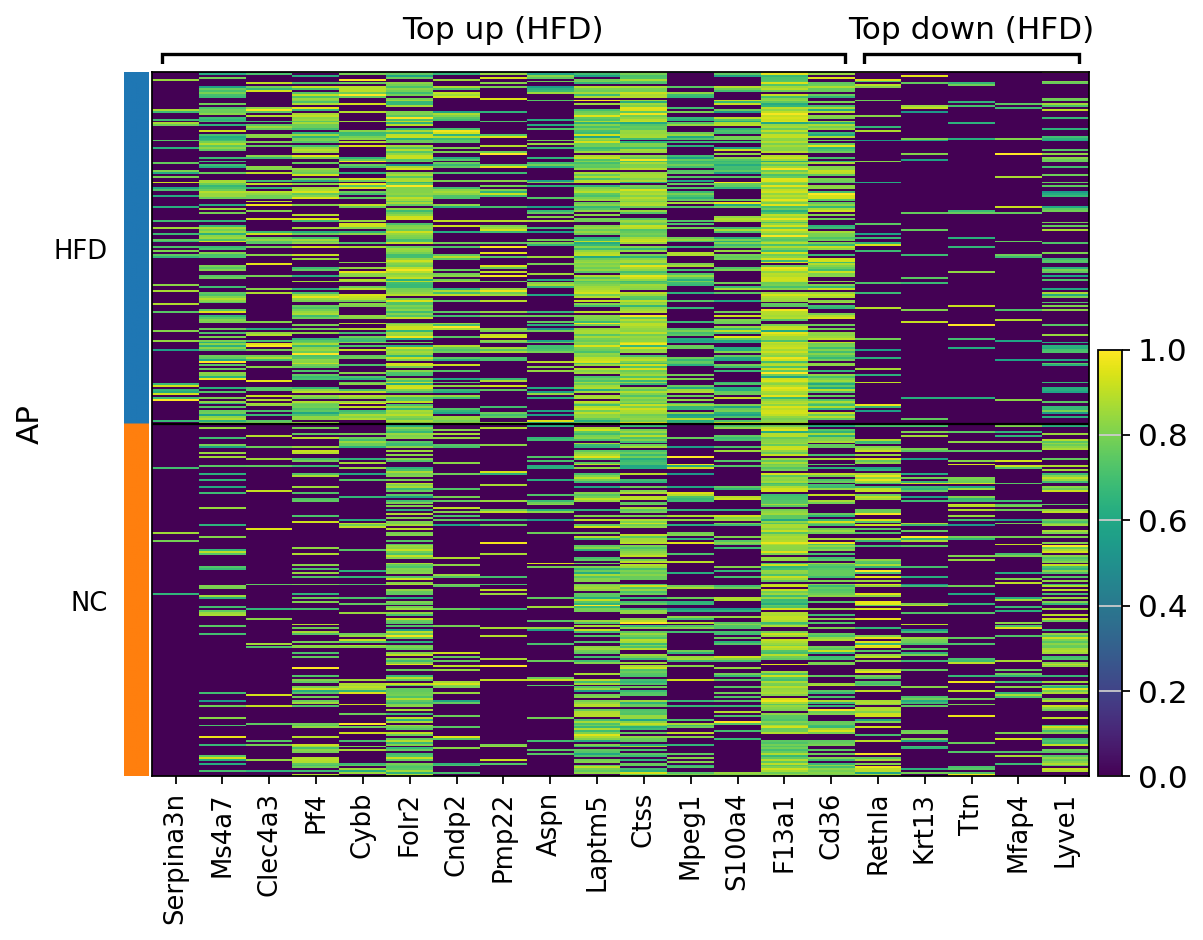

In [33]:

# Build candidate gene list from HFD perspective
top_up   = (hfd_up.sort_values("log2fc", ascending=False)
            .head(N_GENES_UP)["names"].tolist())
top_down = (hfd_down.sort_values("log2fc", ascending=True)
            .head(N_GENES_DOWN)["names"].tolist())
top_genes_all = top_up + top_down

# Keep only genes present
top_genes = [g for g in top_genes_all if g in adata_sub.var_names]
if len(top_genes) < len(top_genes_all):
    missing = set(top_genes_all) - set(top_genes)
    print(f"[warn] Missing in var_names (skipped): {sorted(list(missing))[:10]} ...")

# Downsample to equal cells per group
vc = adata_sub.obs['AP'].value_counts()
min_n = vc.min()
cells_equal = []
for g, sub in adata_sub.obs.groupby('AP'):
    keep_idx = sub.sample(min_n, random_state=RSEED).index
    cells_equal += list(keep_idx)
adata_eq = adata_sub[cells_equal].copy()

# Group headers for columns
n_up = min(N_GENES_UP, len(top_up))
n_dn = min(N_GENES_DOWN, len(top_down))
var_group_positions = [(0, n_up-1), (n_up, n_up + n_dn - 1)]
var_group_labels    = [f"Top up (HFD)", f"Top down (HFD)"]

# Plot
sc.pl.heatmap(
    adata_eq,
    var_names=top_genes,
    groupby="AP",
    layer=layer_used,
    standard_scale="var",
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    var_group_rotation=0,
    figsize=(8, 6),
    show=True
)


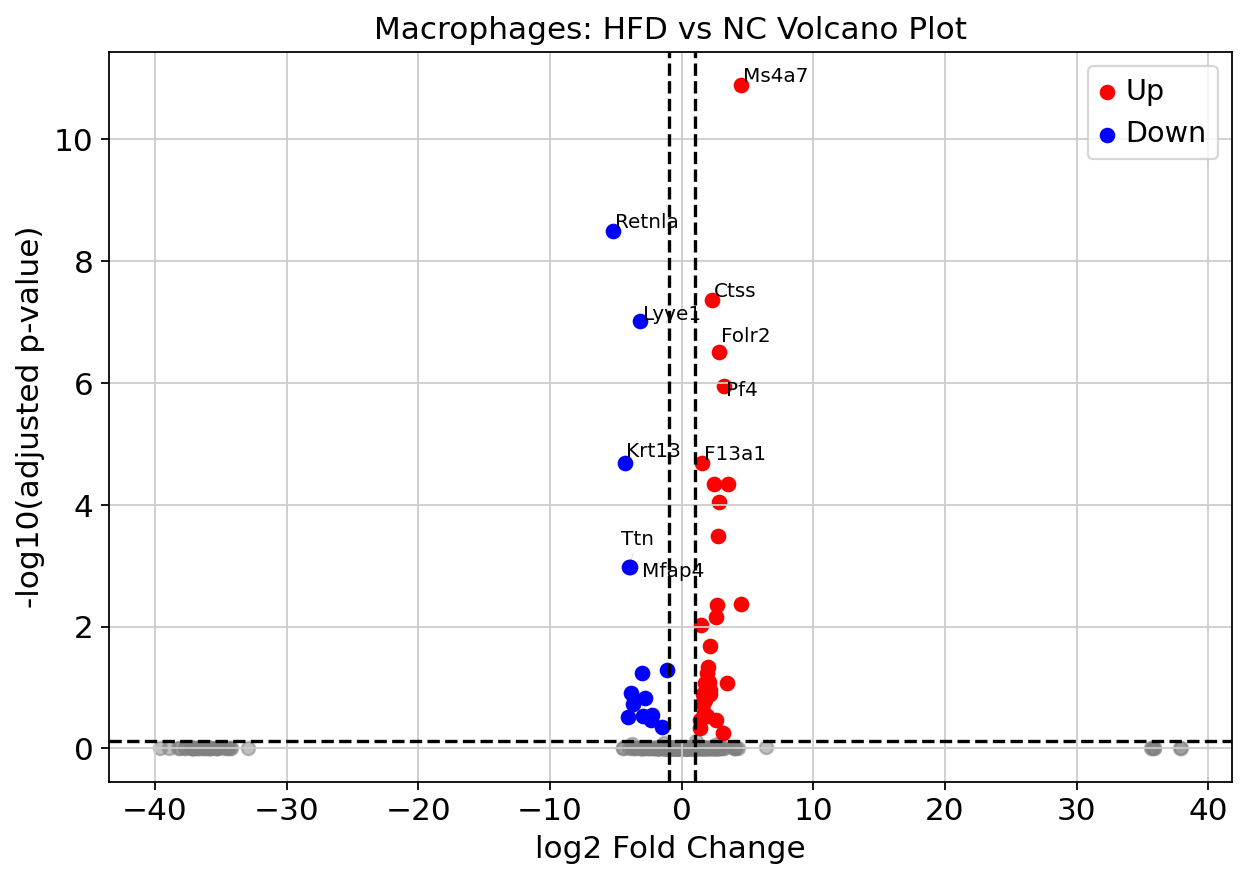

In [34]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------
#  Volcano plot for HFD vs NC
from adjustText import adjust_text

def volcano_plot_annotated(df, title="Volcano plot", l2fc_cut=0.99, p_cut=0.75, top_n=15):
    df = add_log2fc(df)
    plt.figure(figsize=(9,6))

    # Scatter plot of log2FC vs -log10(padj)
    plt.scatter(df["log2fc"], -np.log10(df["pvals_adj"]), color='grey', alpha=0.5)

    # Significant upregulated
    sig_up_genes = sig_up(df, p=p_cut, l2fc=l2fc_cut)
    plt.scatter(sig_up_genes["log2fc"], -np.log10(sig_up_genes["pvals_adj"]),
                color='red', label='Up')

    # Significant downregulated
    sig_down_genes = sig_down(df, p=p_cut, l2fc=l2fc_cut)
    plt.scatter(sig_down_genes["log2fc"], -np.log10(sig_down_genes["pvals_adj"]),
                color='blue', label='Down')

    # Add cutoff lines
    plt.axvline(x=l2fc_cut, color='black', linestyle='--')
    plt.axvline(x=-l2fc_cut, color='black', linestyle='--')
    plt.axhline(y=-np.log10(p_cut), color='black', linestyle='--')

    # --- Annotate top N genes ---
    texts = []
    top_up = sig_up_genes.nsmallest(top_n, "pvals_adj")
    for _, row in top_up.iterrows():
        texts.append(plt.text(row["log2fc"], -np.log10(row["pvals_adj"]), row["names"],
                              fontsize=9, color='black'))

    top_down = sig_down_genes.nsmallest(top_n, "pvals_adj")
    for _, row in top_down.iterrows():
        texts.append(plt.text(row["log2fc"], -np.log10(row["pvals_adj"]), row["names"],
                              fontsize=9, color='black'))

    # Adjust to avoid overlapping labels
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=.05))


    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10(adjusted p-value)')
    plt.title(title)
    plt.legend()
    plt.show()



# Run the annotated volcano plot
volcano_plot_annotated(df_hfd, title="Macrophages: HFD vs NC Volcano Plot", top_n=5)


## 6) GO:BP enrichment via **gseapy/Enrichr**
We use `gseapy.enrichr` with the **GO_Biological_Process_2021** library and plot paired horizontal bars with a framed look.


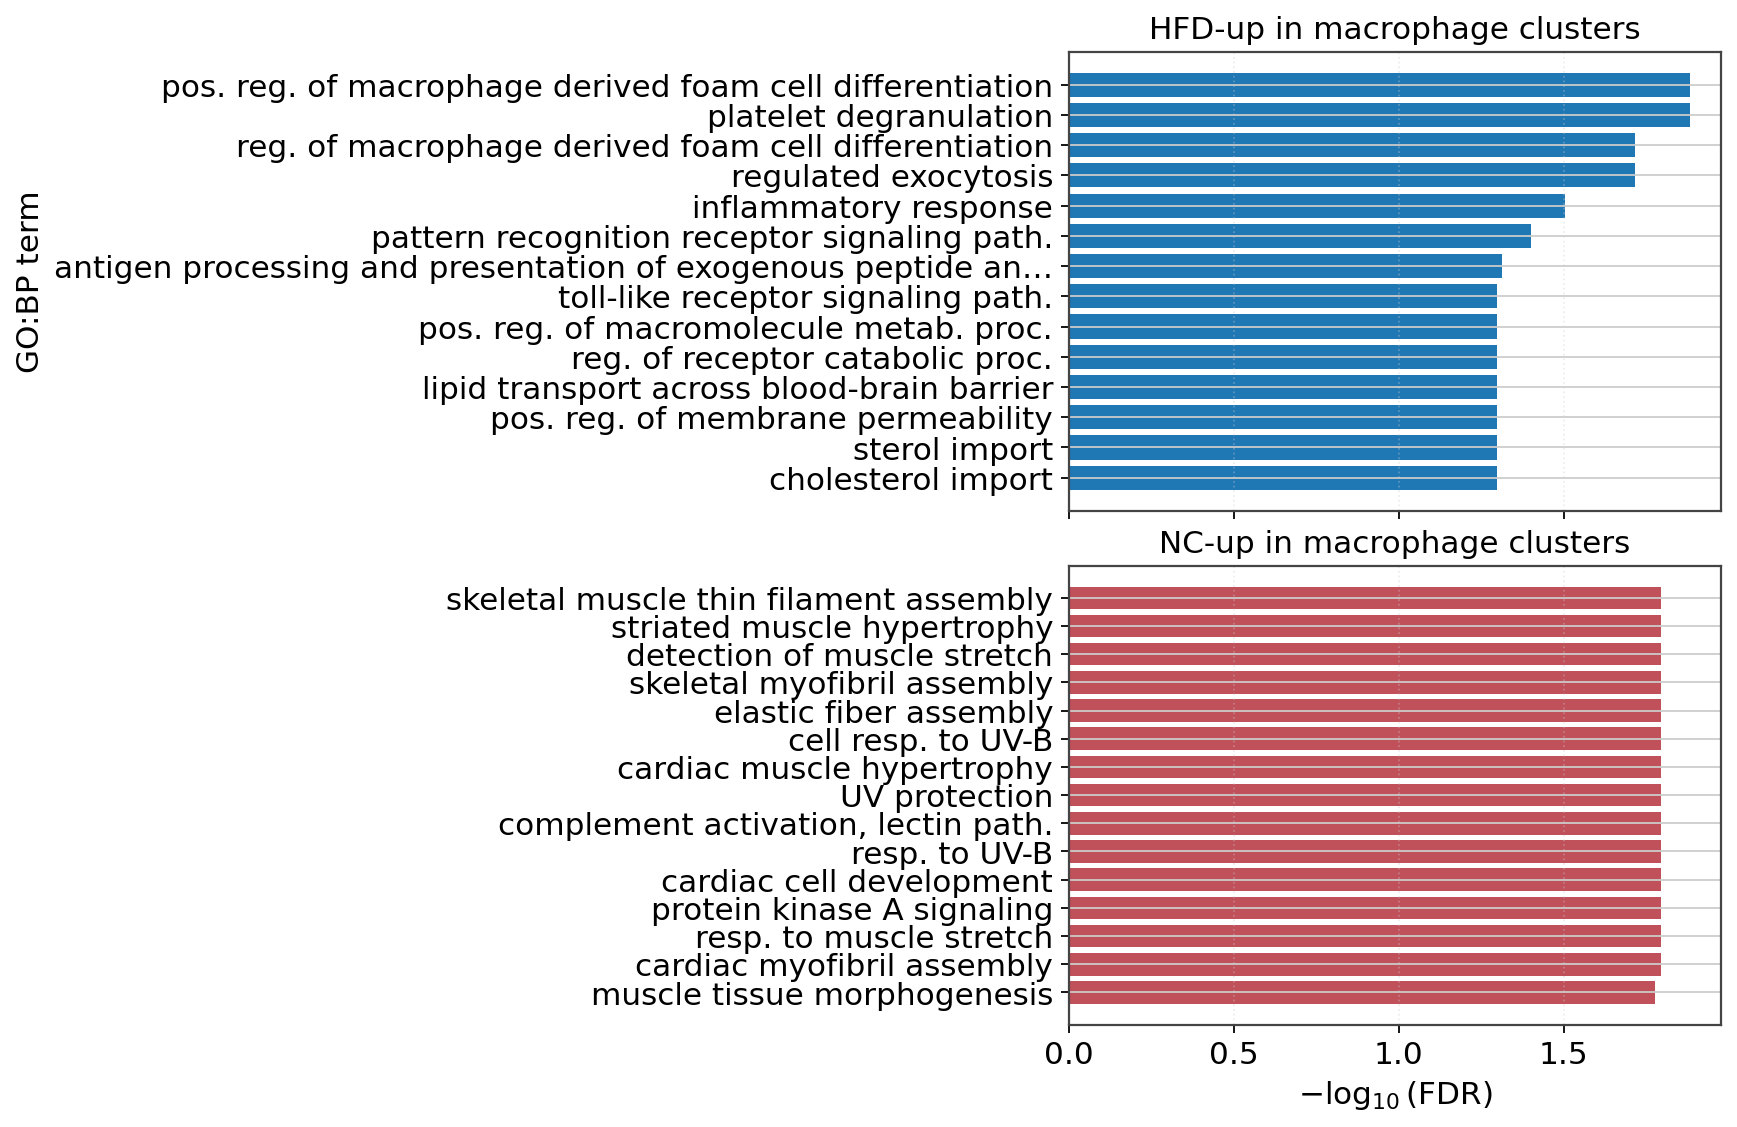

In [35]:
import re, textwrap
import numpy as np, pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

# -------- helper: shorten GO term text --------
def shorten_go_term(term: str, max_words=5, max_chars=42, wrap=False, wrap_width=18):
    if not isinstance(term, str) or not term:
        return term

    t = term

    # remove GO id or trailing brackets
    t = re.sub(r"\s*\(GO:\d+\)\s*$", "", t)          # " ... (GO:0006915)"
    t = re.sub(r"\s*\[.*?\]\s*$", "", t)             # " ... [some db]"

    # common phrase compressions
    repl = {
        "positive regulation of": "pos. reg. of",
        "negative regulation of": "neg. reg. of",
        "regulation of": "reg. of",
        "response to": "resp. to",
        "cellular": "cell",
        "immune system process": "immune proc.",
        "biological process": "bio proc.",
        "signal transduction": "sig. transduction",
        "metabolic process": "metab. proc.",
        "developmental process": "dev. proc.",
        "involved in": "",           # drop filler
        "process": "proc.",          # last, to avoid clobbering earlier phrases
        "activity": "act.",
        "pathway": "path.",
    }
    # apply replacements case-insensitively
    for k, v in repl.items():
        t = re.sub(rf"\b{k}\b", v, t, flags=re.IGNORECASE)

    # trim extra spaces
    t = re.sub(r"\s{2,}", " ", t).strip()

    # word cap
    words = t.split()
    if len(words) > max_words:
        t = " ".join(words[:max_words]) + "…"

    # char cap (final guard)
    if len(t) > max_chars:
        t = t[: max(1, max_chars - 1)].rstrip() + "…"

    # optional wrapping to multiple lines instead of truncation
    if wrap:
        t = "\n".join(textwrap.wrap(t, width=wrap_width))

    return t

# -------- enrich + label-shortening --------
def enrich_gseapy_enrichr(glist, lib="GO_Biological_Process_2021", top=15,
                          max_words=5, max_chars=42, wrap=False, wrap_width=18):
    if not glist:
        return pd.DataFrame()
    enr = gp.enrichr(gene_list=list(glist), gene_sets=[lib], organism="Mouse")
    df = enr.results.copy()
    if df is None or df.empty:
        return pd.DataFrame()
    # harmonize name column
    if "Term" not in df.columns and "term_name" in df.columns:
        df = df.rename(columns={"term_name": "Term"})

    df["neglog10FDR"] = -np.log10(df["Adjusted P-value"].clip(lower=1e-300))
    df = df.sort_values("Adjusted P-value", ascending=True).head(top).reset_index(drop=True)

    # add shortened label
    df["Term_short"] = df["Term"].apply(
        lambda s: shorten_go_term(s, max_words=max_words, max_chars=max_chars, wrap=wrap, wrap_width=wrap_width)
    )
    return df

# -------- plotting with shortened labels --------
def plot_two_enrich_bars(
    enr_top, enr_bottom,
    title_top="GO:BP enrichment — HFD-up (gseapy)",
    title_bottom="GO:BP enrichment — other-up (gseapy)",
    color_top="#1f77b4",
    color_bottom="#c0505a",
    left_margin=0.45,
    save=None,
):
    def _prep(df):
        d = df.copy()
        d = d.sort_values("neglog10FDR", ascending=False)
        return d

    d1 = _prep(enr_top)    if enr_top is not None and not enr_top.empty    else pd.DataFrame()
    d2 = _prep(enr_bottom) if enr_bottom is not None and not enr_bottom.empty else pd.DataFrame()
    if d1.empty and d2.empty:
        print("Nothing to plot.")
        return

    xlim_max = 1.05 * max(
        (d1["neglog10FDR"].max() if not d1.empty else 0.0),
        (d2["neglog10FDR"].max() if not d2.empty else 0.0),
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    fig.subplots_adjust(left=left_margin, hspace=0.12)

    if not d1.empty:
        ax1.barh(d1["Term_short"], d1["neglog10FDR"], color=color_top)
        ax1.invert_yaxis()
        ax1.set_title(title_top)
        ax1.set_ylabel("GO:BP term")
        ax1.set_xlim(0, xlim_max)
        ax1.grid(axis="x", linestyle=":", alpha=0.35)

    if not d2.empty:
        ax2.barh(d2["Term_short"], d2["neglog10FDR"], color=color_bottom)
        ax2.invert_yaxis()
        ax2.set_title(title_bottom)
        ax2.set_xlabel(r"$-\log_{10}(\mathrm{FDR})$")
        ax2.set_xlim(0, xlim_max)
        ax2.grid(axis="x", linestyle=":", alpha=0.35)

    for ax in (ax1, ax2):
        for side in ("left", "right", "top", "bottom"):
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(1.0)
            ax.spines[side].set_color("#444")

    if save:
        plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()

# -------- example run --------
enr_ge_hfd = enrich_gseapy_enrichr(
    hfd_up["names"].tolist(),
    lib="GO_Biological_Process_2021",
    top=15,
    max_words=100,     # tighten/loosen word cap
    max_chars=60,    # tighten/loosen char cap
    wrap=False,      # True -> multi-line instead of ellipses
    wrap_width=18
)
enr_ge_oth = enrich_gseapy_enrichr(
    oth_up["names"].tolist(),
    lib="GO_Biological_Process_2021",
    top=15,
    max_words=100,
    max_chars=420,
    wrap=False,
    wrap_width=18
)

plot_two_enrich_bars(
    enr_ge_hfd, enr_ge_oth,
    title_top="HFD-up in macrophage clusters",
    title_bottom=f"{other_group}-up in macrophage clusters",
    color_top="#1f77b4",
    color_bottom="#c0505a",
    left_margin=0.45,  # increase if labels are still long
)



## 8) Save tables
We write DE tables, gene lists used for heatmap, and both enrichment results for reproducibility.


In [ ]:
# @title

from pathlib import Path

OUT_DIR = Path("/content/cluster_focus_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save DE dataframes
df_hfd.to_csv(OUT_DIR / f"deg_{'_'.join(TARGET_CLUSTERS)}_HFD.csv", index=False)
df_oth.to_csv(OUT_DIR / f"deg_{'_'.join(TARGET_CLUSTERS)}_{other_group}.csv", index=False)

# Save chosen genes for heatmap
pd.Series(top_genes).to_csv(OUT_DIR / f"heatmap_genes_{'_'.join(TARGET_CLUSTERS)}.csv", index=False)

# Save enrichment tables
enr_gp_hfd.to_csv(OUT_DIR / f"gprofiler_goBP_{'_'.join(TARGET_CLUSTERS)}_HFD_up.csv", index=False)
enr_gp_oth.to_csv(OUT_DIR / f"gprofiler_goBP_{'_'.join(TARGET_CLUSTERS)}_{other_group}_up.csv", index=False)
enr_ge_hfd.to_csv(OUT_DIR / f"gseapy_goBP_{'_'.join(TARGET_CLUSTERS)}_HFD_up.csv", index=False)
enr_ge_oth.to_csv(OUT_DIR / f"gseapy_goBP_{'_'.join(TARGET_CLUSTERS)}_{other_group}_up.csv", index=False)

print("Saved to:", OUT_DIR)


## Neutrophils subset

In [36]:

# Pick one or more Leiden clusters (as strings, matching adata.obs['leiden'])
TARGET_CLUSTERS = ["12"]   # e.g., ["10"] or ["6", "7"]

# Differential thresholds
PADJ_CUT   = 0.05
LOG2FC_CUT = 0.75

# Heatmap genes to show (up/down each)
N_GENES_UP   = 20
N_GENES_DOWN = 20

# Random seed for equal downsampling by group
RSEED = 0


In [37]:

import numpy as np
import pandas as pd
import scanpy as sc

assert 'leiden' in adata.obs.columns, "Leiden labels not found in adata.obs['leiden']."
assert 'AP' in adata.obs.columns, "Group labels not found in adata.obs['AP']."

# Validate cluster labels
target = [str(c) for c in TARGET_CLUSTERS]
present = set(adata.obs['leiden'].astype(str).unique())
missing = [c for c in target if c not in present]
if missing:
    raise ValueError(f"Requested clusters {missing} not in adata.obs['leiden'] = {sorted(present)}")

# Subset
sel = adata.obs['leiden'].astype(str).isin(target)
adata_sub = adata[sel].copy()
print("Subset size:", adata_sub.n_obs, "cells,", adata_sub.n_vars, "genes")

# Inspect group balance
print("\nGroup counts within subset:")
print(adata_sub.obs['AP'].value_counts())


Subset size: 3016 cells, 363 genes

Group counts within subset:
AP
NC     2887
HFD     129
Name: count, dtype: int64



## 3) Minimal re-prep (optional)
For a single cluster, we typically **skip HVG re-selection** and reuse the existing normalized layer if available.
If `layers['lognorm']` is missing, we quickly normalize/log-transform here for safety.


In [38]:

# Ensure we have a normalized/log layer
layer_used = "lognorm" if "lognorm" in (adata_sub.layers or {}) else None
if layer_used is None:
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    sc.pp.log1p(adata_sub)
    adata_sub.layers["lognorm"] = adata_sub.X.copy()
    layer_used = "lognorm"
print("Using expression layer:", layer_used)


Using expression layer: lognorm



## 4) Differential expression (HFD vs NC/NC) **within** the subset
We run `rank_genes_groups` on `groupby='AP'` to find genes up/down in **HFD** relative to the other group (NC/NC).


In [39]:

# Identify the two labels present (must be exactly two; assert for safety)
groups_present = list(adata_sub.obs['AP'].astype(str).unique())
if len(groups_present) != 2:
    raise ValueError(f"Expected exactly 2 groups in AP; found {groups_present}")

# Make sure 'HFD' is first for consistent interpretation
if "HFD" not in groups_present:
    raise ValueError(f"'HFD' not found in AP groups: {groups_present}")
other_group = [g for g in groups_present if g != "HFD"][0]  # "NC" or "NC"

# Run DE
sc.tl.rank_genes_groups(
    adata_sub,
    groupby="AP",
    method="wilcoxon",
    pts=True,
    key_added="rg_subset",
    layer=layer_used
)

# Get dataframes for HFD and the other group
df_hfd = sc.get.rank_genes_groups_df(adata_sub, group="HFD",      key="rg_subset")
df_oth = sc.get.rank_genes_groups_df(adata_sub, group=other_group, key="rg_subset")

# Helpers
import numpy as np

def add_log2fc(df):
    d = df.copy()
    if "log2fc" not in d.columns:
        d["log2fc"] = d["logfoldchanges"] / np.log(2)
    return d

def sig_up(df, p=0.05, l2fc=0.75):
    d = add_log2fc(df)
    return d[(d["pvals_adj"] <= p) & (d["log2fc"] >= l2fc)]

def sig_down(df, p=0.05, l2fc=0.75):
    d = add_log2fc(df)
    return d[(d["pvals_adj"] <= p) & (d["log2fc"] <= -l2fc)]

# Significant sets
hfd_up   = sig_up(df_hfd, p=PADJ_CUT, l2fc=LOG2FC_CUT)
hfd_down = sig_down(df_hfd, p=PADJ_CUT, l2fc=LOG2FC_CUT)
oth_up   = sig_up(df_oth, p=PADJ_CUT, l2fc=LOG2FC_CUT)   # up in other group
oth_down = sig_down(df_oth, p=PADJ_CUT, l2fc=LOG2FC_CUT) # down in other group

print("Sig(HFD up):", len(hfd_up), "| Sig(HFD down):", len(hfd_down))
print(f"Sig({other_group} up):", len(oth_up), "| Sig({other_group} down):", len(oth_down))


ranking genes
    finished: added to `.uns['rg_subset']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Sig(HFD up): 22 | Sig(HFD down): 15
Sig(NC up): 15 | Sig({other_group} down): 22


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


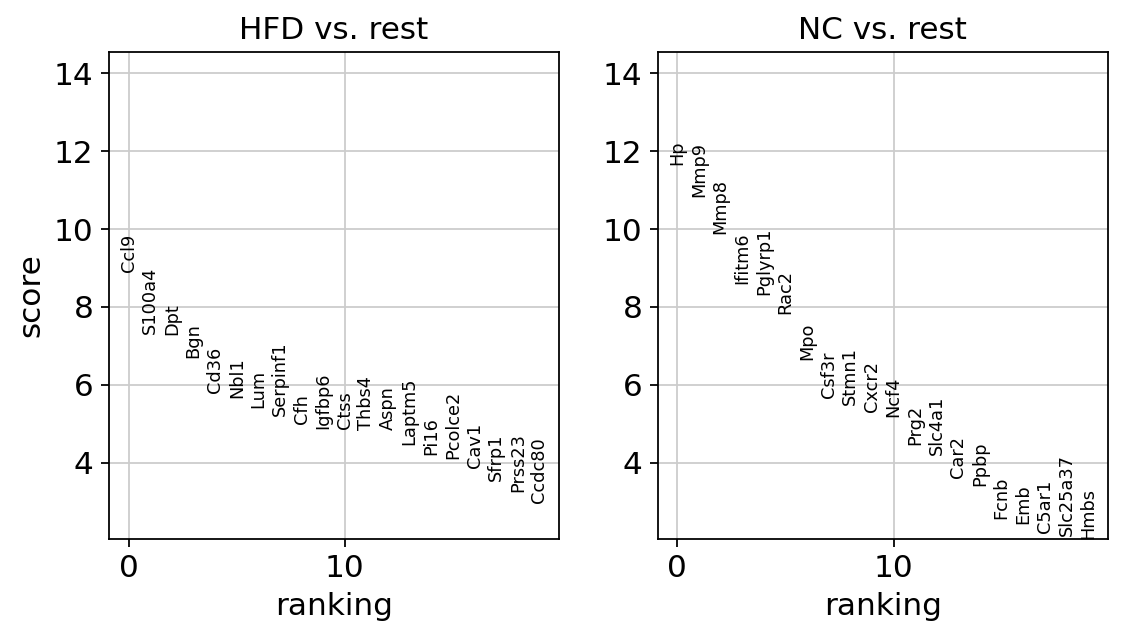

    names    scores  logfoldchanges         pvals     pvals_adj  pct_nz_group  \
0    Ccl9  8.904883        3.665488  5.344242e-19  4.849900e-17      0.744186   
1  S100a4  7.314059        3.130147  2.591911e-13  1.176080e-11      0.682171   
2     Dpt  7.283986        6.331178  3.240987e-13  1.307198e-11      0.395349   
3     Bgn  6.683093        3.084986  2.339509e-11  8.492418e-10      0.612403   
4    Cd36  5.794542        3.840537  6.850769e-09  2.072358e-07      0.372093   

   pct_nz_reference  
0          0.391063  
1          0.370973  
2          0.016626  
3          0.300312  
4          0.068930  


In [40]:
# @title
sc.tl.rank_genes_groups(adata_sub, groupby='AP', method='wilcoxon',layer="lognorm", pts=True)  # sc.tl.rank_genes_groups performs differential expression (DE) analysis between groups of cells.
sc.pl.rank_genes_groups(adata_sub)

# Or convert to a pandas DataFrame for one group
import scanpy as sc
result_df = sc.get.rank_genes_groups_df(adata_sub, group='HFD')
print(result_df.head())



## 5) Heatmap of top genes (keep this; no volcano)
We pick the top **N up** and **N down** genes (by log2FC) for **HFD** and plot a balanced heatmap — downsampling to equal cell counts per group.


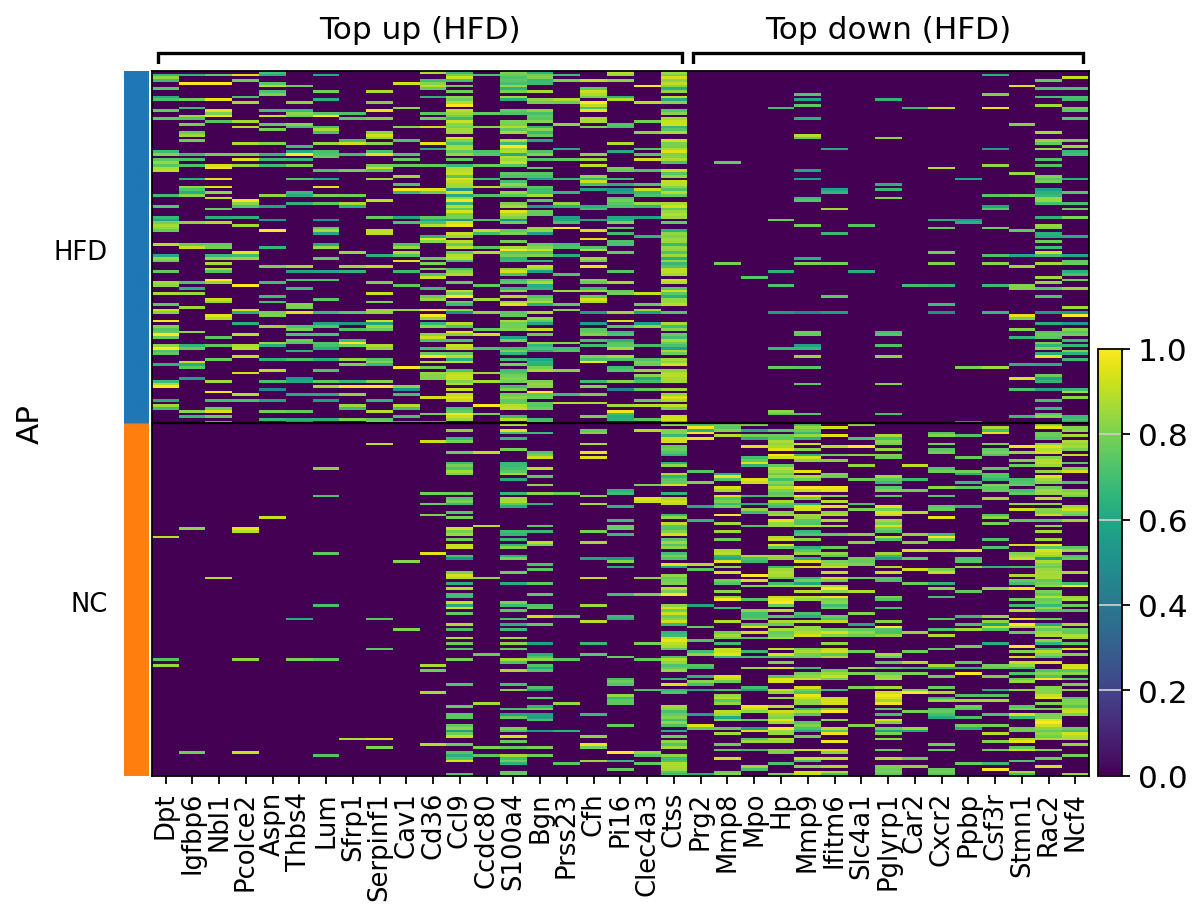

In [41]:

# Build candidate gene list from HFD perspective
top_up   = (hfd_up.sort_values("log2fc", ascending=False)
            .head(N_GENES_UP)["names"].tolist())
top_down = (hfd_down.sort_values("log2fc", ascending=True)
            .head(N_GENES_DOWN)["names"].tolist())
top_genes_all = top_up + top_down

# Keep only genes present
top_genes = [g for g in top_genes_all if g in adata_sub.var_names]
if len(top_genes) < len(top_genes_all):
    missing = set(top_genes_all) - set(top_genes)
    print(f"[warn] Missing in var_names (skipped): {sorted(list(missing))[:10]} ...")

# Downsample to equal cells per group
vc = adata_sub.obs['AP'].value_counts()
min_n = vc.min()
cells_equal = []
for g, sub in adata_sub.obs.groupby('AP'):
    keep_idx = sub.sample(min_n, random_state=RSEED).index
    cells_equal += list(keep_idx)
adata_eq = adata_sub[cells_equal].copy()

# Group headers for columns
n_up = min(N_GENES_UP, len(top_up))
n_dn = min(N_GENES_DOWN, len(top_down))
var_group_positions = [(0, n_up-1), (n_up, n_up + n_dn - 1)]
var_group_labels    = [f"Top up (HFD)", f"Top down (HFD)"]

# Plot
sc.pl.heatmap(
    adata_eq,
    var_names=top_genes,
    groupby="AP",
    layer=layer_used,
    standard_scale="var",
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    var_group_rotation=0,
    figsize=(8, 6),
    show=True
)


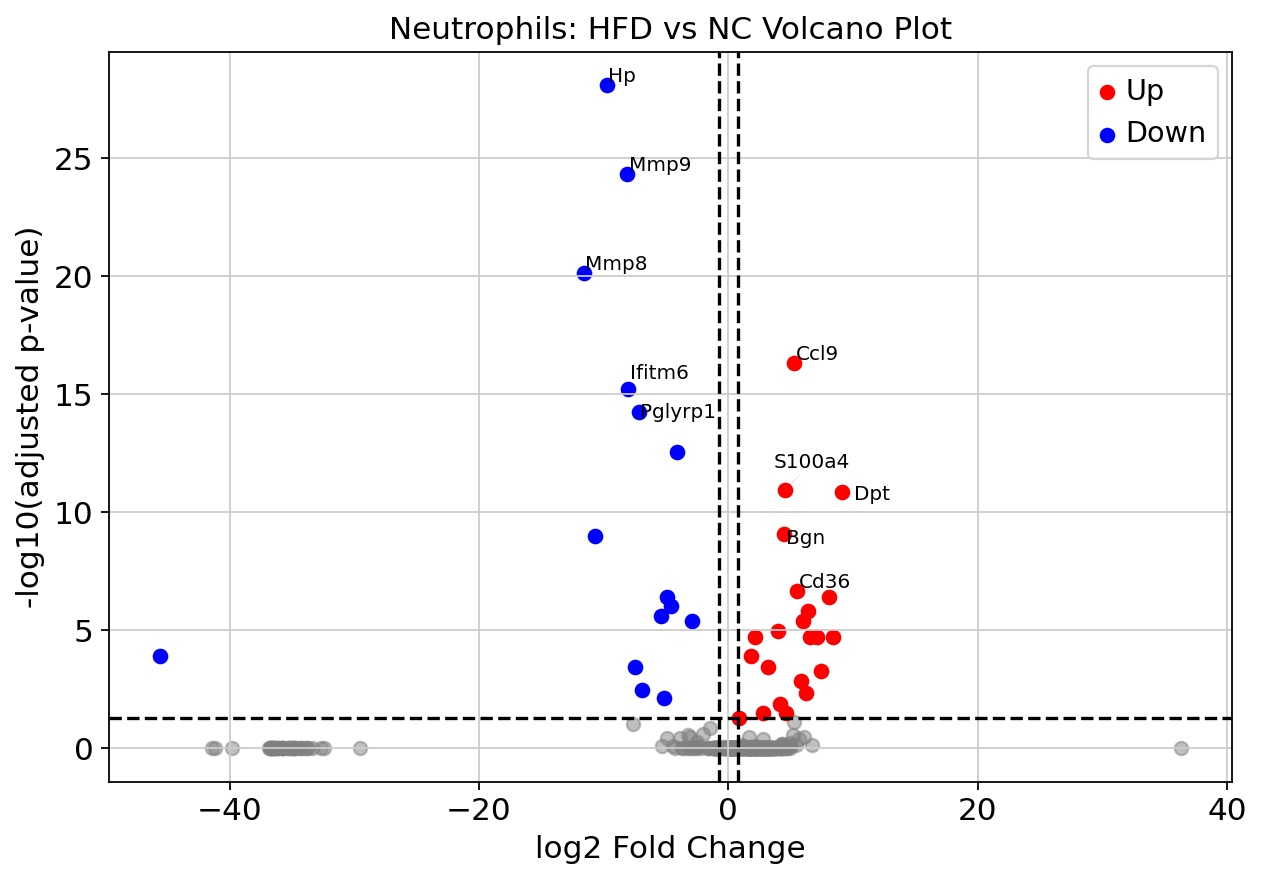

In [42]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------
#  Volcano plot for HFD vs NC
from adjustText import adjust_text

def volcano_plot_annotated(df, title="Volcano plot", l2fc_cut=0.75, p_cut=0.05, top_n=5):
    df = add_log2fc(df)
    plt.figure(figsize=(9,6))

    # Scatter plot of log2FC vs -log10(padj)
    plt.scatter(df["log2fc"], -np.log10(df["pvals_adj"]), color='grey', alpha=0.5)

    # Significant upregulated
    sig_up_genes = sig_up(df, p=p_cut, l2fc=l2fc_cut)
    plt.scatter(sig_up_genes["log2fc"], -np.log10(sig_up_genes["pvals_adj"]),
                color='red', label='Up')

    # Significant downregulated
    sig_down_genes = sig_down(df, p=p_cut, l2fc=l2fc_cut)
    plt.scatter(sig_down_genes["log2fc"], -np.log10(sig_down_genes["pvals_adj"]),
                color='blue', label='Down')

    # Add cutoff lines
    plt.axvline(x=l2fc_cut, color='black', linestyle='--')
    plt.axvline(x=-l2fc_cut, color='black', linestyle='--')
    plt.axhline(y=-np.log10(p_cut), color='black', linestyle='--')

    # --- Annotate top N genes ---
    texts = []
    top_up = sig_up_genes.nsmallest(top_n, "pvals_adj")
    for _, row in top_up.iterrows():
        texts.append(plt.text(row["log2fc"], -np.log10(row["pvals_adj"]), row["names"],
                              fontsize=9, color='black'))

    top_down = sig_down_genes.nsmallest(top_n, "pvals_adj")
    for _, row in top_down.iterrows():
        texts.append(plt.text(row["log2fc"], -np.log10(row["pvals_adj"]), row["names"],
                              fontsize=9, color='black'))

    # Adjust to avoid overlapping labels
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=.05))


    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10(adjusted p-value)')
    plt.title(title)
    plt.legend()
    plt.show()



# Run the annotated volcano plot
volcano_plot_annotated(df_hfd, title="Neutrophils: HFD vs NC Volcano Plot", top_n=5)


## 6) GO:BP enrichment via **gseapy/Enrichr**
We use `gseapy.enrichr` with the **GO_Biological_Process_2021** library and plot paired horizontal bars with a framed look.


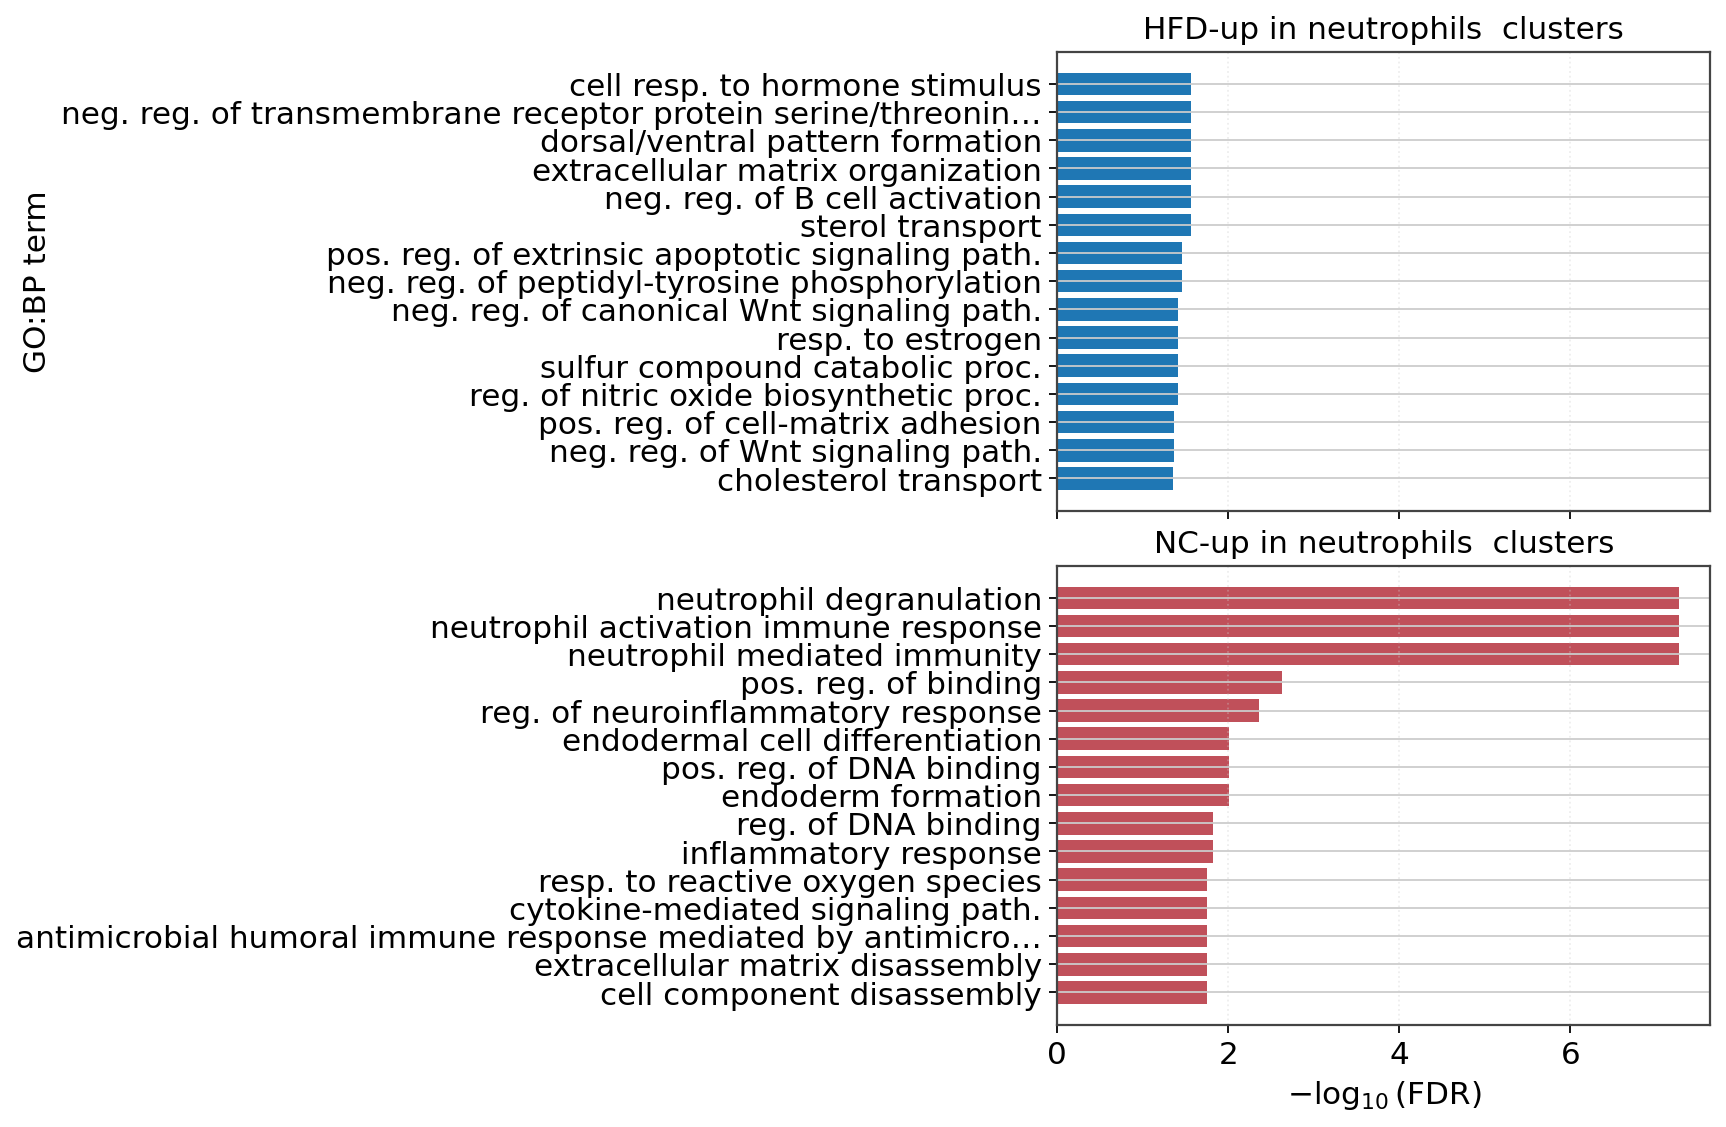

In [43]:
import re, textwrap
import numpy as np, pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

# -------- helper: shorten GO term text --------
def shorten_go_term(term: str, max_words=5, max_chars=42, wrap=False, wrap_width=18):
    if not isinstance(term, str) or not term:
        return term

    t = term

    # remove GO id or trailing brackets
    t = re.sub(r"\s*\(GO:\d+\)\s*$", "", t)          # " ... (GO:0006915)"
    t = re.sub(r"\s*\[.*?\]\s*$", "", t)             # " ... [some db]"

    # common phrase compressions
    repl = {
        "positive regulation of": "pos. reg. of",
        "negative regulation of": "neg. reg. of",
        "regulation of": "reg. of",
        "response to": "resp. to",
        "cellular": "cell",
        "immune system process": "immune proc.",
        "biological process": "bio proc.",
        "signal transduction": "sig. transduction",
        "metabolic process": "metab. proc.",
        "developmental process": "dev. proc.",
        "involved in": "",           # drop filler
        "process": "proc.",          # last, to avoid clobbering earlier phrases
        "activity": "act.",
        "pathway": "path.",
    }
    # apply replacements case-insensitively
    for k, v in repl.items():
        t = re.sub(rf"\b{k}\b", v, t, flags=re.IGNORECASE)

    # trim extra spaces
    t = re.sub(r"\s{2,}", " ", t).strip()

    # word cap
    words = t.split()
    if len(words) > max_words:
        t = " ".join(words[:max_words]) + "…"

    # char cap (final guard)
    if len(t) > max_chars:
        t = t[: max(1, max_chars - 1)].rstrip() + "…"

    # optional wrapping to multiple lines instead of truncation
    if wrap:
        t = "\n".join(textwrap.wrap(t, width=wrap_width))

    return t

# -------- enrich + label-shortening --------
def enrich_gseapy_enrichr(glist, lib="GO_Biological_Process_2021", top=15,
                          max_words=5, max_chars=42, wrap=False, wrap_width=18):
    if not glist:
        return pd.DataFrame()
    enr = gp.enrichr(gene_list=list(glist), gene_sets=[lib], organism="Mouse")
    df = enr.results.copy()
    if df is None or df.empty:
        return pd.DataFrame()
    # harmonize name column
    if "Term" not in df.columns and "term_name" in df.columns:
        df = df.rename(columns={"term_name": "Term"})

    df["neglog10FDR"] = -np.log10(df["Adjusted P-value"].clip(lower=1e-300))
    df = df.sort_values("Adjusted P-value", ascending=True).head(top).reset_index(drop=True)

    # add shortened label
    df["Term_short"] = df["Term"].apply(
        lambda s: shorten_go_term(s, max_words=max_words, max_chars=max_chars, wrap=wrap, wrap_width=wrap_width)
    )
    return df

# -------- plotting with shortened labels --------
def plot_two_enrich_bars(
    enr_top, enr_bottom,
    title_top="GO:BP enrichment — HFD-up (gseapy)",
    title_bottom="GO:BP enrichment — other-up (gseapy)",
    color_top="#1f77b4",
    color_bottom="#c0505a",
    left_margin=0.45,
    save=None,
):
    def _prep(df):
        d = df.copy()
        d = d.sort_values("neglog10FDR", ascending=False)
        return d

    d1 = _prep(enr_top)    if enr_top is not None and not enr_top.empty    else pd.DataFrame()
    d2 = _prep(enr_bottom) if enr_bottom is not None and not enr_bottom.empty else pd.DataFrame()
    if d1.empty and d2.empty:
        print("Nothing to plot.")
        return

    xlim_max = 1.05 * max(
        (d1["neglog10FDR"].max() if not d1.empty else 0.0),
        (d2["neglog10FDR"].max() if not d2.empty else 0.0),
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    fig.subplots_adjust(left=left_margin, hspace=0.12)

    if not d1.empty:
        ax1.barh(d1["Term_short"], d1["neglog10FDR"], color=color_top)
        ax1.invert_yaxis()
        ax1.set_title(title_top)
        ax1.set_ylabel("GO:BP term")
        ax1.set_xlim(0, xlim_max)
        ax1.grid(axis="x", linestyle=":", alpha=0.35)

    if not d2.empty:
        ax2.barh(d2["Term_short"], d2["neglog10FDR"], color=color_bottom)
        ax2.invert_yaxis()
        ax2.set_title(title_bottom)
        ax2.set_xlabel(r"$-\log_{10}(\mathrm{FDR})$")
        ax2.set_xlim(0, xlim_max)
        ax2.grid(axis="x", linestyle=":", alpha=0.35)

    for ax in (ax1, ax2):
        for side in ("left", "right", "top", "bottom"):
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(1.0)
            ax.spines[side].set_color("#444")

    if save:
        plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()

# -------- example run --------
enr_ge_hfd = enrich_gseapy_enrichr(
    hfd_up["names"].tolist(),
    lib="GO_Biological_Process_2021",
    top=15,
    max_words=100,     # tighten/loosen word cap
    max_chars=60,    # tighten/loosen char cap
    wrap=False,      # True -> multi-line instead of ellipses
    wrap_width=18
)
enr_ge_oth = enrich_gseapy_enrichr(
    oth_up["names"].tolist(),
    lib="GO_Biological_Process_2021",
    top=15,
    max_words=100,
    max_chars=60,
    wrap=False,
    wrap_width=18
)

plot_two_enrich_bars(
    enr_ge_hfd, enr_ge_oth,
    title_top="HFD-up in neutrophils  clusters",
    title_bottom=f"{other_group}-up in neutrophils  clusters",
    color_top="#1f77b4",
    color_bottom="#c0505a",
    left_margin=0.45,  # increase if labels are still long
)


**sanity-check whether neutrophil-looking GO terms in HFD macrophages are biology (HFD effect) or mis-annotation / contamination.**

ranking genes
    finished: added to `.uns['rg_mac']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rg_neu']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
[HFD-up]  Mac 15 vs Neu 22 -> common 6 | Jaccard=0.194 | OverlapCoeff=0.400
[HFD-down] Mac 5 vs Neu 15 -> common 0 | Jaccard=0.000 | OverlapCoeff=0.000
[NC-up] Mac 5 vs Neu 15 -> common 0 | Jaccard=0.000 | OverlapCoeff=0.000

Common HFD-up genes (first 3

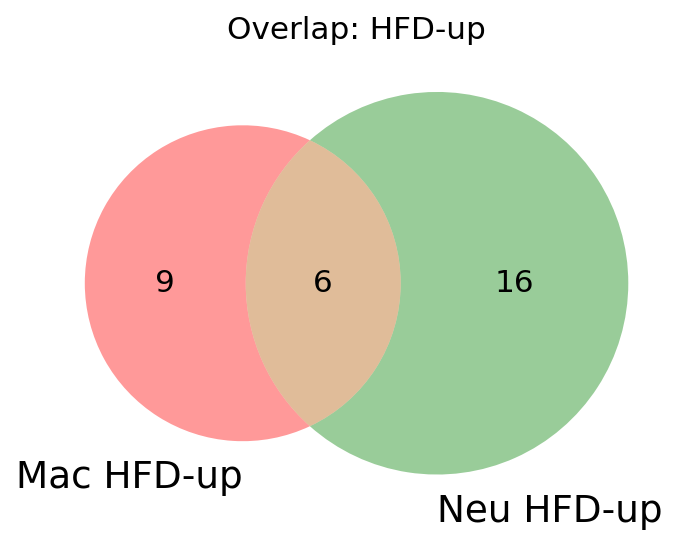

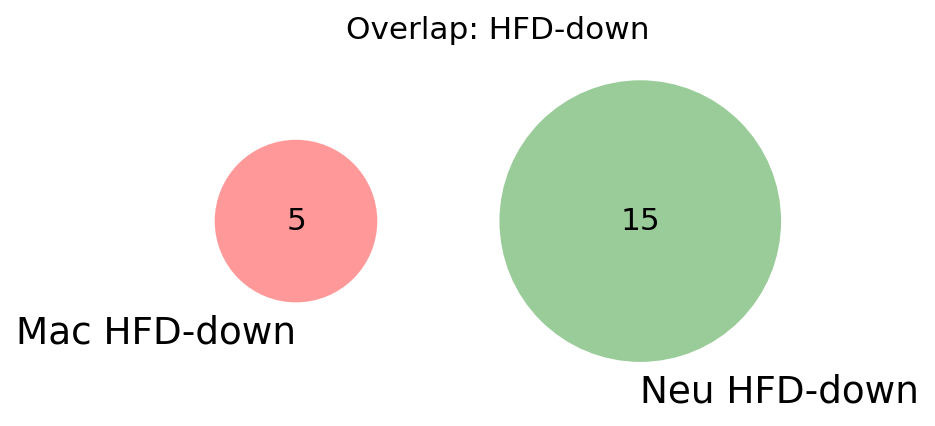

In [44]:
# === Choose cluster IDs for each lineage ===
MAC_CLUSTERS = ["13"]      # e.g., macrophage cluster(s)
NEU_CLUSTERS = ["12"]      # e.g., neutrophil cluster(s)

# --- helpers   already defined (sig_up/sig_down/add_log2fc) assumed present ---

def deg_for_clusters(adata, clusters, groupby="AP", method="wilcoxon", layer="lognorm",
                     p=0.05, l2fc=0.75, key="rg_tmp"):
    """Run DE HFD vs other_group within the selected clusters and return 4 tidy dfs."""
    sel = adata.obs['leiden'].astype(str).isin([str(c) for c in clusters])
    ad = adata[sel].copy()
    if layer not in (ad.layers or {}):
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.layers["lognorm"] = ad.X.copy()
        layer = "lognorm"

    groups_present = list(ad.obs[groupby].astype(str).unique())
    assert "HFD" in groups_present and len(groups_present) == 2, f"Groups present: {groups_present}"
    other_group = [g for g in groups_present if g != "HFD"][0]

    sc.tl.rank_genes_groups(ad, groupby=groupby, method=method, pts=True, key_added=key, layer=layer)
    df_hfd = sc.get.rank_genes_groups_df(ad, group="HFD", key=key)
    df_oth = sc.get.rank_genes_groups_df(ad, group=other_group, key=key)

    hfd_up   = sig_up(df_hfd, p=p, l2fc=l2fc)
    hfd_down = sig_down(df_hfd, p=p, l2fc=l2fc)
    oth_up   = sig_up(df_oth, p=p, l2fc=l2fc)
    oth_down = sig_down(df_oth, p=p, l2fc=l2fc)

    return hfd_up, hfd_down, oth_up, oth_down, other_group

def sets_from_df(df):
    return set(df["names"].astype(str)) if not df.empty else set()

def overlap_stats(a, b):
    inter = a & b
    jacc  = len(inter) / len(a | b) if (a or b) else 0.0
    # Overlap coefficient (Szymkiewicz–Simpson)
    ovlp  = len(inter) / min(len(a), len(b)) if min(len(a), len(b)) else 0.0
    return inter, jacc, ovlp

# --- run for each lineage ---
mac_hfd_up, mac_hfd_dn, mac_oth_up, mac_oth_dn, mac_other = deg_for_clusters(
    adata, MAC_CLUSTERS, p=PADJ_CUT, l2fc=LOG2FC_CUT, key="rg_mac"
)
neu_hfd_up, neu_hfd_dn, neu_oth_up, neu_oth_dn, neu_other = deg_for_clusters(
    adata, NEU_CLUSTERS, p=PADJ_CUT, l2fc=LOG2FC_CUT, key="rg_neu"
)

# --- build sets ---
S_mac_up   = sets_from_df(mac_hfd_up)
S_mac_down = sets_from_df(mac_hfd_dn)
S_neu_up   = sets_from_df(neu_hfd_up)
S_neu_down = sets_from_df(neu_hfd_dn)

# --- compute overlaps (HFD-up vs HFD-up, etc.) ---
inter_up,  j_up,  o_up  = overlap_stats(S_mac_up, S_neu_up)
inter_dn,  j_dn,  o_dn  = overlap_stats(S_mac_down, S_neu_down)

print(f"[HFD-up]  Mac {len(S_mac_up)} vs Neu {len(S_neu_up)} -> common {len(inter_up)} | "
      f"Jaccard={j_up:.3f} | OverlapCoeff={o_up:.3f}")
print(f"[HFD-down] Mac {len(S_mac_down)} vs Neu {len(S_neu_down)} -> common {len(inter_dn)} | "
      f"Jaccard={j_dn:.3f} | OverlapCoeff={o_dn:.3f}")

# Optional: also check “other group” (e.g., NC-up) symmetry
S_mac_oth_up   = sets_from_df(mac_oth_up)
S_neu_oth_up   = sets_from_df(neu_oth_up)
inter_oth_up, j_oth_up, o_oth_up = overlap_stats(S_mac_oth_up, S_neu_oth_up)
print(f"[{mac_other}-up] Mac {len(S_mac_oth_up)} vs Neu {len(S_neu_oth_up)} -> "
      f"common {len(inter_oth_up)} | Jaccard={j_oth_up:.3f} | OverlapCoeff={o_oth_up:.3f}")

# Show the actual common genes (top 30)
print("\nCommon HFD-up genes (first 30):", sorted(list(inter_up))[:30])
print("Common HFD-down genes (first 30):", sorted(list(inter_dn))[:30])

# --- optional: quick Venns (requires matplotlib-venn) ---
try:
    import matplotlib.pyplot as plt
    from matplotlib_venn import venn2

    plt.figure(figsize=(5,4))
    venn2([S_mac_up, S_neu_up], set_labels=("Mac HFD-up", "Neu HFD-up"))
    plt.title("Overlap: HFD-up")
    plt.show()

    plt.figure(figsize=(5,4))
    venn2([S_mac_down, S_neu_down], set_labels=("Mac HFD-down", "Neu HFD-down"))
    plt.title("Overlap: HFD-down")
    plt.show()
except Exception as e:
    print("[info] Venn skipped:", e)
